In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

SITES = ["BSB","MAO"]
ZONES = ["DORM1"]
BASE_PATH = Path("../data/processed")

In [3]:
from scipy.stats import spearmanr

In [4]:
def load_full_parquet(site_id: str, zone: str):
    parquet = BASE_PATH / site_id / f"{site_id}_{zone}_1991-2023_FULL_PIPELINE.parquet"
    df = pd.read_parquet(parquet)  # deixa o pandas escolher o engine

    # garantir datetime
    df["timeset"] = pd.to_datetime(df["timeset"], errors="coerce")
    df = df.dropna(subset=["timeset"])

    # garantir chaves de cenário
    if "scenario" not in df.columns:
        raise ValueError("Coluna 'scenario' não encontrada no FULL_PIPELINE (esperado em multi-casos).")

    # coluna CASE canônica (Caso1/Caso2/Caso3), útil p/ cruzar VN vs AC
    df["CASE"] = df["scenario"].str.replace(r"_(vn|ac)$", "", regex=True)

    # checagem rápida (evita bugs silenciosos)
    if df.duplicated(subset=["scenario", "timeset"]).any():
        ndup = int(df.duplicated(subset=["scenario", "timeset"]).sum())
        raise ValueError(f"Duplicatas encontradas em (scenario,timeset): {ndup}")

    # index temporal
    df = df.set_index("timeset").sort_index()

    # metadados úteis
    df["SITE_ID"] = site_id
    df["ZONE"] = zone

    return df

In [5]:
fulls = {}
dfs = []

for site_id in SITES:
    for zone in ZONES:
        df = load_full_parquet(site_id, zone)

        # opcional: manter também no dict
        fulls[(site_id, zone)] = df

        # volta timeset para coluna para facilitar merges/groupby/plots multi-site
        dfs.append(df.reset_index())  # timeset vira coluna de novo

df_all = pd.concat(dfs, axis=0, ignore_index=True)

# checagem rápida
print(df_all[["SITE_ID","ZONE","scenario","CASE"]].drop_duplicates().sort_values(["SITE_ID","CASE","scenario"]).head(20))
print("rows:", len(df_all), "| unique timeset:", df_all["timeset"].nunique())

       SITE_ID   ZONE  scenario   CASE
0          BSB  DORM1  Caso1_vn  Caso1
1          BSB  DORM1  Caso2_vn  Caso2
2          BSB  DORM1  Caso3_vn  Caso3
867240     MAO  DORM1  Caso1_vn  Caso1
867241     MAO  DORM1  Caso2_vn  Caso2
867242     MAO  DORM1  Caso3_vn  Caso3
rows: 1734480 | unique timeset: 289080


In [23]:
full = fulls[("MAO", "DORM1")]

In [24]:
df_all.groupby("SITE_ID").size()

SITE_ID
BSB    867240
MAO    867240
dtype: int64

In [25]:
df_all.head()

,timeset,site_id,year,month,day,hour,ta_c,tdp_c,rh_pct,p_atm_pa,...,ac_SALA_Cool_P_W,ac_DORM1_Heat_E_kWh,ac_DORM1_Cool_E_kWh,ac_DORM2_Heat_E_kWh,ac_DORM2_Cool_E_kWh,ac_SALA_Heat_E_kWh,ac_SALA_Cool_E_kWh,CASE,SITE_ID,ZONE
0,1991-01-01 01:00:00,BSB,1991,1,1,1,19.2,16.8,86,89311,...,488.933430,0.0,0.188928,0.0,0.169107,0.0,0.488933,Caso1,BSB,DORM1
1,1991-01-01 01:00:00,BSB,1991,1,1,1,19.2,16.8,86,89311,...,217.367233,0.0,0.085714,0.0,0.078740,0.0,0.217367,Caso2,BSB,DORM1
2,1991-01-01 01:00:00,BSB,1991,1,1,1,19.2,16.8,86,89311,...,492.945688,0.0,0.191113,0.0,0.175662,0.0,0.492946,Caso3,BSB,DORM1
3,1991-01-01 02:00:00,BSB,1991,1,1,2,19.0,17.0,88,89635,...,410.338741,0.0,0.161038,0.0,0.145263,0.0,0.410339,Caso1,BSB,DORM1
4,1991-01-01 02:00:00,BSB,1991,1,1,2,19.0,17.0,88,89635,...,188.539815,0.0,0.079084,0.0,0.073545,0.0,0.188540,Caso2,BSB,DORM1


Caracterização das ondas de calor

In [26]:
full["OUZ_hw_id"].describe()

count                       13896
unique                         27
top       MAO-Ouzeau-20150917-002
freq                         1440
Name: OUZ_hw_id, dtype: object

In [27]:
def count_events_by_id(full, bool_col, id_col):
    h = full[bool_col].astype(bool)
    if id_col not in full.columns:
        return np.nan
    ids = full.loc[h, id_col].astype(str)
    ids = ids[ids.notna() & (ids != "nan") & (ids != "None") & (ids != "")]
    return int(ids.nunique()) if len(ids) else 0

def hw_summary_one(full: pd.DataFrame, site: str):
    rows = []

    for method, bool_col, id_col, dur_col in [
        ("INMET",  "HW_INMET_bool", "INMET_hw_id", "INMET_duration_d"),
        ("Ouzeau", "HW_OU_bool",    "OUZ_hw_id",   "OUZ_duration_d"),
    ]:
        if bool_col not in full.columns:
            continue

        h = full[bool_col].astype(bool).fillna(False)
        total_hours = len(full)

        hw_hours = int(h.sum())
        hw_pct   = 100 * hw_hours / total_hours if total_hours else np.nan

        # ---- número de eventos (IDs únicos) ----
        n_ids = np.nan
        if id_col in full.columns:
            ids = full.loc[h, id_col].astype(str)
            ids = ids[ids.notna() & (ids != "nan") & (ids != "None") & (ids != "")]
            n_ids = int(ids.nunique()) if len(ids) else 0

        # ---- duração por evento (em dias) ----
        mean_dur = np.nan
        med_dur  = np.nan
        if dur_col in full.columns:
            d = pd.to_numeric(full.loc[h, dur_col], errors="coerce").dropna()
            if len(d):
                mean_dur = float(d.mean())
                med_dur  = float(d.median())

        rows.append({
            "SITE": site,
            "Method": method,
            "HW_hours": hw_hours,
            "HW_pct_hours": hw_pct,
            "N_events_ids": n_ids,
            "Mean_duration_d": mean_dur,
            "Median_duration_d": med_dur,
        })

    return pd.DataFrame(rows)

hw_summary = pd.concat(
    [hw_summary_one(df, site_id[0]) for site_id, df in fulls.items()],
    ignore_index=True
)

hw_summary

,SITE,Method,HW_hours,HW_pct_hours,N_events_ids,Mean_duration_d,Median_duration_d
0,BSB,INMET,3306,0.381209,22,4.155172,5.0
1,BSB,Ouzeau,13272,1.530372,32,8.153481,7.0
2,MAO,INMET,225,0.025944,3,2.000000,2.0
3,MAO,Ouzeau,12033,1.387505,27,10.591124,9.0


Definição de períodos extremos

In [28]:
CRITICAL_DEF = {
    # Definição A: "Extremo relativo ao clima" (top 1%)
    "relative_quantile": 0.99,      # p99 = top 1% das horas

    # Definição B: "Crítico fisiológico absoluto" (interpretable)
    "core_abs_threshold_c": 38.0,   # exemplo: Tcore >= 39°C

    # Para dias críticos
    "min_hours_per_day": 2
}

In [29]:
def make_relative_extreme_flag(df: pd.DataFrame, col: str, q: float = 0.99, suffix: str = None):
    """
    Cria flag booleana de extremo relativo: col >= quantil q (calculado no próprio df).
    Retorna: df com a coluna flag e o valor do limiar usado.
    """
    if col not in df.columns:
        raise KeyError(f"Coluna '{col}' não existe no dataframe.")

    s = df[col].astype(float)
    thr = s.quantile(q, interpolation="linear")  # consistente e simples
    flag_name = suffix or f"flag_extreme_{col}_q{int(q*100)}"

    df[flag_name] = s >= thr
    return df, thr, flag_name

def make_absolute_threshold_flag(df: pd.DataFrame, col: str, thr: float, flag_name: str):
    """
    Cria flag booleana por limiar absoluto (ex.: t_core >= 38°C).
    """
    if col not in df.columns:
        raise KeyError(f"Coluna '{col}' não existe no dataframe.")

    s = df[col].astype(float)
    df[flag_name] = s >= thr
    return df, flag_name

def make_daily_critical_flag(df: pd.DataFrame, hourly_flag_col: str, min_hours_per_day: int = 2,
                            daily_flag_name: str = None):
    """
    Converte flag horária em flag diária:
    dia crítico se tiver >= min_hours_per_day horas críticas.
    """
    if hourly_flag_col not in df.columns:
        raise KeyError(f"Coluna '{hourly_flag_col}' não existe no dataframe.")

    daily_flag_name = daily_flag_name or f"day_critical_{hourly_flag_col}_ge{min_hours_per_day}h"
    daily_counts = df[hourly_flag_col].resample("D").sum().astype(int)
    daily_flag = daily_counts >= min_hours_per_day

    # devolve uma série diária; se quiser “colar” no df horário, dá pra mapear depois
    return daily_counts, daily_flag.rename(daily_flag_name)


def create_critical_flags(full: pd.DataFrame, CRITICAL_DEF: dict):
    """
    Cria flags de períodos críticos por SCENARIO (sem misturar Caso1/2/3).
    """
    full = full.copy()

    REL_VARS = [
        "vn_DORM1_Top_C",
        "vn_DORM1_HeatIndex_C",
        "vn_DORM1_HumidityIndex",
        "ac_DORM1_Cool_P_W",
        "jos3_t_core_age30",
        "jos3_t_core_age75",
        "jos3_t_skin_mean_age30",
        "jos3_t_skin_mean_age75",
    ]

    # (recomendado) limpa flags antigas para evitar “estado sujo”
    for c in list(full.columns):
        if c.startswith("flag_extreme_") or c.startswith("flag_critical_core_abs_"):
            full.drop(columns=[c], inplace=True)

    for scenario in full["scenario"].unique():
        mask = full["scenario"] == scenario

        for col in REL_VARS:
            if col not in full.columns:
                continue

            s = full.loc[mask, col].astype(float)
            thr = s.quantile(
                CRITICAL_DEF["relative_quantile"],
                interpolation="linear"
            )

            flag = f"flag_extreme_{col}_p99"
            full.loc[mask, flag] = s >= thr

    # limiar absoluto fisiológico
    thr_abs = CRITICAL_DEF["core_abs_threshold_c"]

    if "jos3_t_core_age30" in full.columns:
        full["flag_critical_core_abs_age30"] = full["jos3_t_core_age30"].astype(float) >= thr_abs

    if "jos3_t_core_age75" in full.columns:
        full["flag_critical_core_abs_age75"] = full["jos3_t_core_age75"].astype(float) >= thr_abs

    return full


In [30]:
for (site_id, zone), df in fulls.items():
    fulls[(site_id, zone)] = create_critical_flags(df, CRITICAL_DEF)

In [31]:
# 2A) Definição A (relativa): top 1% por variável
REL_VARS = [
    "vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    "ac_DORM1_Cool_P_W",
    "jos3_t_core_age30",
    "jos3_t_core_age75",
    "jos3_t_skin_mean_age30",
    "jos3_t_skin_mean_age75"
]

thresholds_used = {}   # {(scenario, col): thr}
flags_created = []

for scenario in full["scenario"].unique():
    mask = full["scenario"] == scenario

    for col in REL_VARS:
        if col not in full.columns:
            continue

        s = full.loc[mask, col].astype(float)

        thr = s.quantile(
            CRITICAL_DEF["relative_quantile"],
            interpolation="linear"
        )

        flag = f"flag_extreme_{col}_p99"
        full.loc[mask, flag] = s >= thr

        thresholds_used[(scenario, col)] = thr
        flags_created.append(flag)

In [32]:
thr_df = (
    pd.Series(thresholds_used)
      .rename("p99_threshold")
      .reset_index()
      .rename(columns={"level_0": "scenario", "level_1": "variable"})
)

thr_df

,scenario,variable,p99_threshold
0,Caso1_vn,vn_DORM1_Top_C,36.204284
1,Caso1_vn,vn_DORM1_HeatIndex_C,46.795491
2,Caso1_vn,vn_DORM1_HumidityIndex,49.641604
3,Caso1_vn,ac_DORM1_Cool_P_W,1100.839033
4,Caso1_vn,jos3_t_core_age30,36.930000
5,Caso1_vn,jos3_t_core_age75,37.420000
6,Caso1_vn,jos3_t_skin_mean_age30,35.900000
7,Caso1_vn,jos3_t_skin_mean_age75,36.110000
8,Caso2_vn,vn_DORM1_Top_C,35.750917
9,Caso2_vn,vn_DORM1_HeatIndex_C,46.611477


In [33]:
thr_pivot = (
    thr_df
    .pivot(
        index="variable",
        columns="scenario",
        values="p99_threshold"
    )
    .round(2)
    .sort_index()
)

thr_pivot


scenario,Caso1_vn,Caso2_vn,Caso3_vn
variable,,,
ac_DORM1_Cool_P_W,1100.84,615.17,1023.39
jos3_t_core_age30,36.93,36.91,36.95
jos3_t_core_age75,37.42,37.39,37.44
jos3_t_skin_mean_age30,35.90,35.85,35.95
jos3_t_skin_mean_age75,36.11,36.04,36.16
vn_DORM1_HeatIndex_C,46.80,46.61,47.10
vn_DORM1_HumidityIndex,49.64,49.53,49.87
vn_DORM1_Top_C,36.20,35.75,36.62


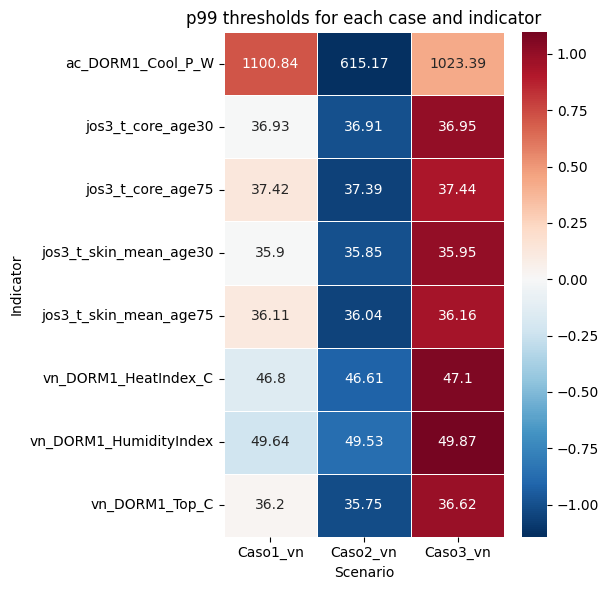

In [35]:
thr_z = thr_pivot.sub(thr_pivot.mean(axis=1), axis=0)
thr_z = thr_z.div(thr_pivot.std(axis=1), axis=0)

plt.figure(figsize=(6, 6))
sns.heatmap(
    thr_z,
    annot=thr_pivot.round(2),
    fmt="",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)

plt.title("p99 thresholds for each case and indicator")
plt.xlabel("Scenario")
plt.ylabel("Indicator")
plt.tight_layout()
plt.show()

In [15]:
# 2B) Definição B (absoluta fisiológica): core acima do limiar

if "jos3_t_core_age30" in full.columns:
    full, flag_core_abs = make_absolute_threshold_flag(
        full,
        col="jos3_t_core_age30",
        thr=CRITICAL_DEF["core_abs_threshold_c"],
        flag_name="flag_critical_core_abs_age30"
    )

if "jos3_t_core_age75" in full.columns:
    full, flag_core_abs = make_absolute_threshold_flag(
        full,
        col="jos3_t_core_age75",
        thr=CRITICAL_DEF["core_abs_threshold_c"],
        flag_name="flag_critical_core_abs_age75"
    )

# (opcional) Dia crítico para core absoluto 
daily_core = {}  # daily_core[scenario][age] = {...}

for scenario, g in full.groupby("scenario"):
    g = g.sort_index()  # garante index temporal ordenado
    daily_core[scenario] = {}

    for age in ["age30", "age75"]:
        flag_col = f"flag_critical_core_abs_{age}"
        if flag_col not in g.columns:
            continue

        daily_hours, daily_flag = make_daily_critical_flag(
            g,
            hourly_flag_col=flag_col,
            min_hours_per_day=CRITICAL_DEF["min_hours_per_day"],
            daily_flag_name=f"day_critical_core_abs_{age}"
        )

        daily_core[scenario][age] = {
            "daily_hours": daily_hours,
            "daily_flag": daily_flag
        }

In [16]:
summary_rows = []

# flags relativas (p99) – já criadas antes
for scen, g in full.groupby("scenario"):
    # flags p99
    for f in flags_created:
        if f not in g.columns:
            continue
        summary_rows.append({
            "scenario": scen,
            "flag": f,
            "n_hours": int(g[f].sum()),
            "pct_hours": float(g[f].mean() * 100),
        })

    # flags absolutas (por idade)
    for age in ["age30", "age75"]:
        f = f"flag_critical_core_abs_{age}"
        if f not in g.columns:
            continue
        summary_rows.append({
            "scenario": scen,
            "flag": f,
            "n_hours": int(g[f].sum()),
            "pct_hours": float(g[f].mean() * 100),
        })

summary_df = (
    pd.DataFrame(summary_rows)
      .sort_values(["flag", "scenario"])
      .reset_index(drop=True)
)

summary_df


,scenario,flag,n_hours,pct_hours
0,Caso1_vn,flag_critical_core_abs_age30,0,0.000000
1,Caso2_vn,flag_critical_core_abs_age30,0,0.000000
2,Caso3_vn,flag_critical_core_abs_age30,0,0.000000
3,Caso1_vn,flag_critical_core_abs_age75,0,0.000000
4,Caso2_vn,flag_critical_core_abs_age75,0,0.000000
...,...,...,...,...
73,Caso2_vn,flag_extreme_vn_DORM1_Top_C_p99,2891,1.000069
74,Caso2_vn,flag_extreme_vn_DORM1_Top_C_p99,2891,1.000069
75,Caso3_vn,flag_extreme_vn_DORM1_Top_C_p99,2891,1.000069
76,Caso3_vn,flag_extreme_vn_DORM1_Top_C_p99,2891,1.000069


In [17]:
summary_wide = summary_df.pivot_table(
    index="flag",
    columns="scenario",
    values="pct_hours"
).sort_index()

summary_wide

scenario,Caso1_vn,Caso2_vn,Caso3_vn
flag,,,
flag_critical_core_abs_age30,0.000000,0.000000,0.000000
flag_critical_core_abs_age75,0.000000,0.000000,0.000000
flag_extreme_ac_DORM1_Cool_P_W_p99,1.000069,1.000069,1.000069
flag_extreme_jos3_t_core_age30_p99,1.622388,2.409022,1.461533
flag_extreme_jos3_t_core_age75_p99,1.061298,1.425903,1.014598
flag_extreme_jos3_t_skin_mean_age30_p99,1.107306,1.018403,1.020133
flag_extreme_jos3_t_skin_mean_age75_p99,1.115954,1.002837,1.049191
flag_extreme_vn_DORM1_HeatIndex_C_p99,1.000069,1.000069,1.000069
flag_extreme_vn_DORM1_HumidityIndex_p99,1.000069,1.000069,1.000069


In [18]:
desc = (
    full
    .groupby("scenario")[[
        "jos3_t_core_age30",
        "jos3_t_core_age75"
    ]]
    .describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
)

desc

jos3_t_core_age30                                                   \
                     count       mean       std    min     1%     5%    50%   
scenario                                                                      
Caso1_vn          289072.0  36.611164  0.157745  36.33  36.39  36.39  36.60   
Caso2_vn          289072.0  36.572670  0.150684  36.37  36.39  36.39  36.51   
Caso3_vn          289072.0  36.625297  0.158374  36.35  36.39  36.39  36.65   

                              jos3_t_core_age75                              \
            95%    99%    max             count       mean       std    min   
scenario                                                                      
Caso1_vn  36.81  36.83  36.89          289072.0  36.909408  0.166794  36.59   
Caso2_vn  36.80  36.81  36.86          289072.0  36.869393  0.147570  36.65   
Caso3_vn  36.82  36.84  36.90          289072.0  36.926413  0.173078  36.61   

                                                    
             1%     5%    50%    95%    99%    max  
scenario                                            
Caso1_vn  36.71  36.73  36.84  37.19  37.24  37.35  
Caso2_vn  36.71  36.73  36.80  37.16  37.20  37.30  
Caso3_vn  36.72  36.73  36.85  37.21  37.26  37.37

In [19]:
# Conferir se o limiar e o % fazem sentido
for k,v in list(thresholds_used.items())[:6]:
    print(f"{k}: p99={v:.3f}")

('Caso1_vn', 'vn_DORM1_Top_C'): p99=32.184
('Caso1_vn', 'vn_DORM1_HeatIndex_C'): p99=32.511
('Caso1_vn', 'vn_DORM1_HumidityIndex'): p99=37.888
('Caso1_vn', 'ac_DORM1_Cool_P_W'): p99=769.279
('Caso1_vn', 'jos3_t_core_age30'): p99=36.830
('Caso1_vn', 'jos3_t_core_age75'): p99=37.240


Coocorrência simultânea entre indicadores (hora a hora)

Índice de Jaccard

J(A,B)=∣A∩B∣/∣A∪B∣

0 → nunca ocorrem juntos
1 → sempre ocorrem juntos

In [20]:
# Flags a comparar 
FLAGS = {
    "Temp. Op.": "flag_extreme_vn_DORM1_Top_C_p99",
    "Heat Index": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "Cool. Power": "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "Core Temp.": "flag_extreme_jos3_t_core_age30_p99",
}

# manter apenas flags existentes
FLAGS = {k:v for k,v in FLAGS.items() if v in full.columns}

# checagem rápida
full[list(FLAGS.values())].mean().sort_values(ascending=False) * 100

flag_extreme_jos3_t_core_age30_p99       1.830981
flag_extreme_vn_DORM1_Top_C_p99          1.000069
flag_extreme_vn_DORM1_HeatIndex_C_p99    1.000069
flag_extreme_ac_DORM1_Cool_P_W_p99       1.000069
dtype: object

In [21]:
def jaccard_index(a: pd.Series, b: pd.Series):
    """
    Calcula índice de Jaccard entre duas séries booleanas.
    Ignora NaNs automaticamente.
    """
    a = a.astype(bool)
    b = b.astype(bool)
    intersection = (a & b).sum()
    union = (a | b).sum()
    return intersection / union if union > 0 else np.nan

In [22]:
jaccard_all = {}  # {(site, scenario): matrix}

for (site_id, zone), df_site in fulls.items():
    
    for scenario, g in df_site.groupby("scenario"):

        labels = list(FLAGS.keys())
        jaccard_mat = pd.DataFrame(index=labels, columns=labels, dtype=float)

        for li in labels:
            for lj in labels:
                jaccard_mat.loc[li, lj] = jaccard_index(
                    g[FLAGS[li]],
                    g[FLAGS[lj]]
                )

        jaccard_all[(site_id, scenario)] = jaccard_mat


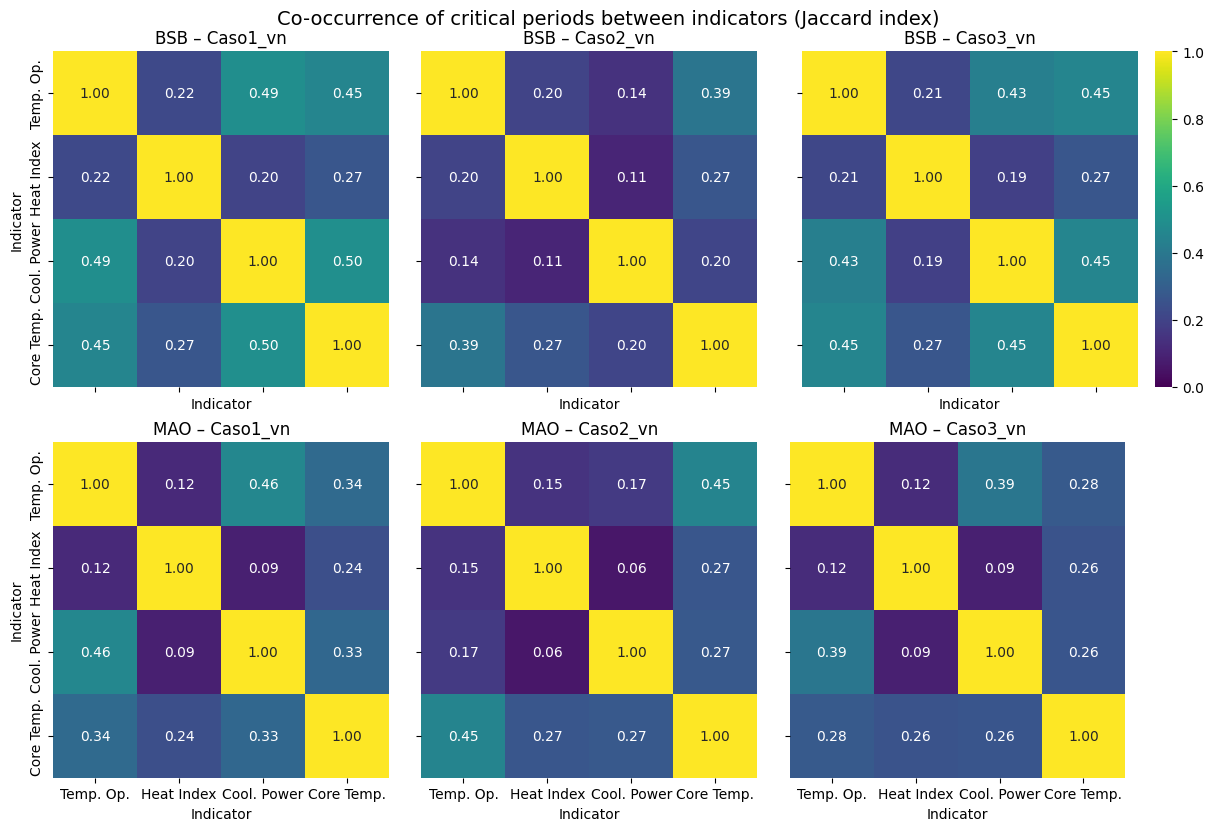

In [23]:
sites = ["BSB", "MAO"]
scenarios = ["Caso1_vn", "Caso2_vn", "Caso3_vn"]

fig, axes = plt.subplots(
    nrows=len(sites),
    ncols=len(scenarios),
    figsize=(4 * len(scenarios), 4 * len(sites)),
    constrained_layout=True,
    sharex=True,
    sharey=True
)

for i, site in enumerate(sites):
    for j, scen in enumerate(scenarios):
        ax = axes[i, j]

        mat = jaccard_all.get((site, scen))
        if mat is None:
            ax.axis("off")
            continue

        sns.heatmap(
            mat,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            vmin=0, vmax=1,
            square=True,
            cbar=(i == 0 and j == len(scenarios) - 1),  # uma colorbar só
            ax=ax
        )

        ax.set_title(f"{site} – {scen}")
        ax.set_xlabel("Indicator")
        ax.set_ylabel("Indicator" if j == 0 else "")

fig.suptitle(
    "Co-occurrence of critical periods between indicators (Jaccard index)",
    fontsize=14,
    y=1.02
)

plt.show()


Core_abs: Probabilidade condicional

P(Indicador∣Core_abs)

In [24]:
core_flag = "flag_critical_core_abs_age75"

out = []

for scen, g in full.groupby("scenario"):
    if core_flag not in g.columns:
        continue

    core_abs = g[core_flag].fillna(False).astype(bool)
    n_core = int(core_abs.sum())

    for name, flag in FLAGS.items():
        if flag == core_flag:
            continue
        if flag not in g.columns:
            continue

        pct = np.nan
        if n_core > 0:
            pct = float(g.loc[core_abs, flag].fillna(False).astype(bool).mean() * 100)

        out.append({
            "scenario": scen,
            "indicator": name,
            "P(indicador extremo | Core_abs) [%]": pct,
            "n_core_hours": n_core,
        })

cond_df = pd.DataFrame(out).sort_values(["indicator","scenario"]).reset_index(drop=True)
cond_df


,scenario,indicator,P(indicador extremo | Core_abs) [%],n_core_hours
0,Caso1_vn,Cool. Power,NaN,0
1,Caso2_vn,Cool. Power,NaN,0
2,Caso3_vn,Cool. Power,NaN,0
3,Caso1_vn,Core Temp.,NaN,0
4,Caso2_vn,Core Temp.,NaN,0
5,Caso3_vn,Core Temp.,NaN,0
6,Caso1_vn,Heat Index,NaN,0
7,Caso2_vn,Heat Index,NaN,0
8,Caso3_vn,Heat Index,NaN,0
9,Caso1_vn,Temp. Op.,NaN,0


Análise de ondas de calor

Risk Ratio (RR)

Para cada indicador crítico:

RR=P(critico∣HW)/P(critico∣No HW)

Interpretação:

RR = 1 → HW não muda nada
RR > 1 → HW aumenta a chance de período crítico
RR < 1 → período crítico ocorre mais fora de HW

In [25]:
def risk_ratio(flag_critical: pd.Series, flag_hw: pd.Series):
    """
    RR = P(critical | HW) / P(critical | no HW)
    Retorna NaN se não dá para calcular.
    """
    c = flag_critical.fillna(False).astype(bool)
    h = flag_hw.fillna(False).astype(bool)

    if h.sum() == 0 or (~h).sum() == 0:
        return np.nan  # sem HW ou sem não-HW

    p_hw = c[h].mean()
    p_no = c[~h].mean()

    if p_no == 0:
        return np.nan

    return p_hw / p_no

In [26]:
CRIT_FLAGS = {
    "Top": "flag_extreme_vn_DORM1_Top_C_p99",
    "HI": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "Energy": "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "Core_rel_30": "flag_extreme_jos3_t_core_age30_p99",
    "Core_rel_75": "flag_extreme_jos3_t_core_age75_p99",
    "Core_abs_30": "flag_critical_core_abs_age30",
    "Core_abs_75": "flag_critical_core_abs_age75",
}

HW_FLAGS = {
    "INMET": "HW_INMET_bool",
    "Ouzeau": "HW_OU_bool",
}

rows = []

for (site_id, zone), df_site in fulls.items():
    for scen, g in df_site.groupby("scenario"):
        for crit_name, crit_col in CRIT_FLAGS.items():
            if crit_col not in g.columns:
                continue
            for hw_name, hw_col in HW_FLAGS.items():
                if hw_col not in g.columns:
                    continue

                rr = risk_ratio(g[crit_col], g[hw_col])

                rows.append({
                    "SITE": site_id,
                    "ZONE": zone,
                    "scenario": scen,
                    "Indicator": crit_name,
                    "HW_def": hw_name,
                    "Risk_Ratio": rr,
                    "n_HW_hours": int(g[hw_col].fillna(False).astype(bool).sum()),
                })

rr_all = pd.DataFrame(rows)
rr_all


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2770778866.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  c = flag_critical.fillna(False).astype(bool)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2770778866.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  c = flag_critical.fillna(False).astype(bool)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2770778866.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead.

,SITE,ZONE,scenario,Indicator,HW_def,Risk_Ratio,n_HW_hours
0,BSB,DORM1,Caso1_vn,Top,INMET,34.945553,1102
1,BSB,DORM1,Caso1_vn,Top,Ouzeau,34.234740,4424
2,BSB,DORM1,Caso1_vn,HI,INMET,19.839934,1102
3,BSB,DORM1,Caso1_vn,HI,Ouzeau,11.674928,4424
4,BSB,DORM1,Caso1_vn,Energy,INMET,29.471768,1102
...,...,...,...,...,...,...,...
79,MAO,DORM1,Caso3_vn,Core_rel_75,Ouzeau,18.205335,4011
80,MAO,DORM1,Caso3_vn,Core_abs_30,INMET,NaN,75
81,MAO,DORM1,Caso3_vn,Core_abs_30,Ouzeau,NaN,4011
82,MAO,DORM1,Caso3_vn,Core_abs_75,INMET,NaN,75


In [27]:
rr_wide = rr_all.pivot_table(
    index=["SITE","ZONE","Indicator","HW_def"],
    columns="scenario",
    values="Risk_Ratio"
).sort_index()

rr_wide


scenario                        Caso1_vn   Caso2_vn   Caso3_vn
SITE ZONE  Indicator   HW_def                                 
BSB  DORM1 Core_rel_30 INMET   24.699145  16.178280  25.007315
                       Ouzeau  19.715303  14.089589  18.512752
           Core_rel_75 INMET   33.650871  24.854849  32.339979
                       Ouzeau  26.334465  20.827980  24.049732
           Energy      INMET   29.471768  20.890225  25.933580
                       Ouzeau  21.418195  10.063336  16.886678
           HI          INMET   19.839934  18.382591  17.865766
                       Ouzeau  11.674928  11.028093  10.633159
           Top         INMET   34.945553  32.983509  34.134493
                       Ouzeau  34.234740  31.938661  31.839093
MAO  DORM1 Core_rel_30 INMET   15.805578  14.837554  14.940485
                       Ouzeau  17.185099  10.914202  13.275062
           Core_rel_75 INMET   19.773701  17.289512  18.695148
                       Ouzeau  22.673580  12.754077  18.205335
           Energy      INMET   20.097705  20.097705  21.445009
                       Ouzeau  16.998742   3.752881  12.215016
           HI          INMET    4.002839   4.002839   5.338968
                       Ouzeau   5.395850   4.384893   5.027672
           Top         INMET   18.751338  20.097705  18.751338
                       Ouzeau  32.700208  25.076340  30.645317

Risk Ratio por cidade

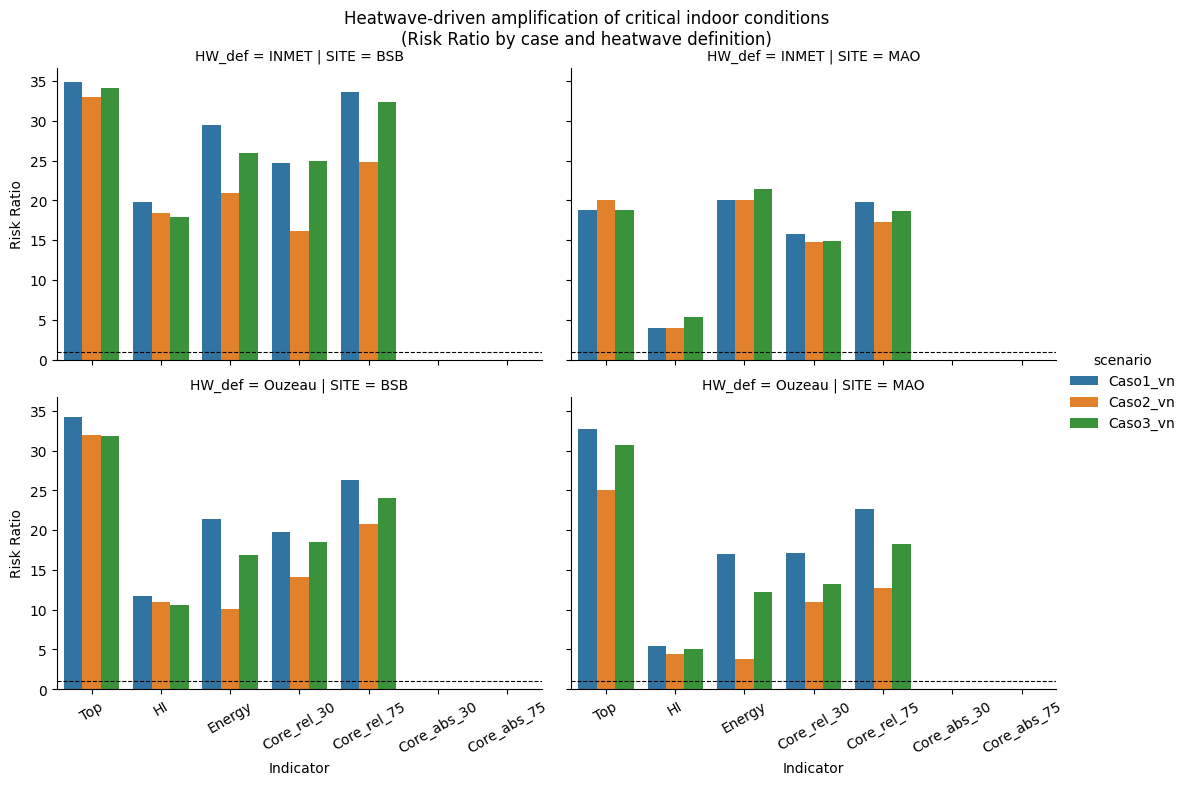

In [28]:
plot_df = rr_all.query("Indicator != 'Core_abs'")

g = sns.catplot(
    data=plot_df,
    x="Indicator",
    y="Risk_Ratio",
    hue="scenario",
    col="SITE",
    row="HW_def",
    kind="bar",
    errorbar=None,
    height=4,
    aspect=1.35
)

for ax in g.axes.flat:
    ax.axhline(1, color="k", ls="--", lw=0.8)
    ax.tick_params(axis="x", rotation=30)   # ← AQUI é o certo

g.set_axis_labels("Indicator", "Risk Ratio")

g.fig.subplots_adjust(bottom=0.18)

g.fig.suptitle(
    "Heatwave-driven amplification of critical indoor conditions\n"
    "(Risk Ratio by case and heatwave definition)",
    y=1.03
)

plt.show()


In [29]:
def frac_critical_in_hw(flag: pd.Series, hw_flag: pd.Series):
    flag = flag.fillna(False).astype(bool)
    hw_flag = hw_flag.fillna(False).astype(bool)

    denom = int(flag.sum())
    if denom == 0:
        return np.nan

    return float((flag & hw_flag).sum() / denom)


In [30]:
results_frac = []

INDS = {
    "Temp. Op.": "flag_extreme_vn_DORM1_Top_C_p99",
    "Heat Index": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "Cool. Power": "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "Core Temp.": "flag_extreme_jos3_t_core_age30_p99",
    "Core_abs": "flag_critical_core_abs_age30",
}

for (site_id, zone), df_site in fulls.items():
    for scen, g in df_site.groupby("scenario"):
        for ind, col in INDS.items():
            if col not in g.columns:
                continue

            for hw_def, hw_col in [("INMET","HW_INMET_bool"), ("Ouzeau","HW_OU_bool")]:
                if hw_col not in g.columns:
                    continue

                frac = frac_critical_in_hw(g[col], g[hw_col])

                results_frac.append({
                    "SITE": site_id,
                    "ZONE": zone,
                    "scenario": scen,
                    "Indicator": ind,
                    "HW_def": hw_def,
                    "Frac_in_HW": frac * 100 if pd.notna(frac) else np.nan,
                })

frac_all = pd.DataFrame(results_frac)
frac_all

C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3083613139.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  flag = flag.fillna(False).astype(bool)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3083613139.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  flag = flag.fillna(False).astype(bool)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3083613139.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in t

,SITE,ZONE,scenario,Indicator,HW_def,Frac_in_HW
0,BSB,DORM1,Caso1_vn,Temp. Op.,INMET,11.795227
1,BSB,DORM1,Caso1_vn,Temp. Op.,Ouzeau,34.728468
2,BSB,DORM1,Caso1_vn,Heat Index,INMET,7.056382
3,BSB,DORM1,Caso1_vn,Heat Index,Ouzeau,15.358008
4,BSB,DORM1,Caso1_vn,Cool. Power,INMET,10.134901
5,BSB,DORM1,Caso1_vn,Cool. Power,Ouzeau,24.974057
6,BSB,DORM1,Caso1_vn,Core Temp.,INMET,8.635394
7,BSB,DORM1,Caso1_vn,Core Temp.,Ouzeau,23.454158
8,BSB,DORM1,Caso1_vn,Core_abs,INMET,NaN
9,BSB,DORM1,Caso1_vn,Core_abs,Ouzeau,NaN


In [31]:
frac_wide = frac_all.pivot_table(
    index=["SITE","ZONE","Indicator","HW_def"],
    columns="scenario",
    values="Frac_in_HW"
).sort_index()

frac_wide

scenario                        Caso1_vn   Caso2_vn   Caso3_vn
SITE ZONE  Indicator   HW_def                                 
BSB  DORM1 Cool. Power INMET   10.134901   7.402283   9.028018
                       Ouzeau  24.974057  13.524732  20.788654
           Core Temp.  INMET    8.635394   5.829983   8.733728
                       Ouzeau  23.454158  17.963814  22.343195
           Heat Index  INMET    7.056382   6.572120   6.399170
                       Ouzeau  15.358008  14.631615  14.181944
           Temp. Op.   INMET   11.795227  11.207195  11.553096
                       Ouzeau  34.728468  33.171913  33.102733
MAO  DORM1 Cool. Power INMET    0.518852   0.518852   0.553442
                       Ouzeau  19.301280   5.015566  14.666205
           Core Temp.  INMET    0.408497   0.383574   0.386225
                       Ouzeau  19.471678  13.312274  15.738655
           Heat Index  INMET    0.103770   0.103770   0.138360
                       Ouzeau   7.056382   5.811138   6.606710
           Temp. Op.   INMET    0.484262   0.518852   0.484262
                       Ouzeau  31.511588  26.080941  30.127983

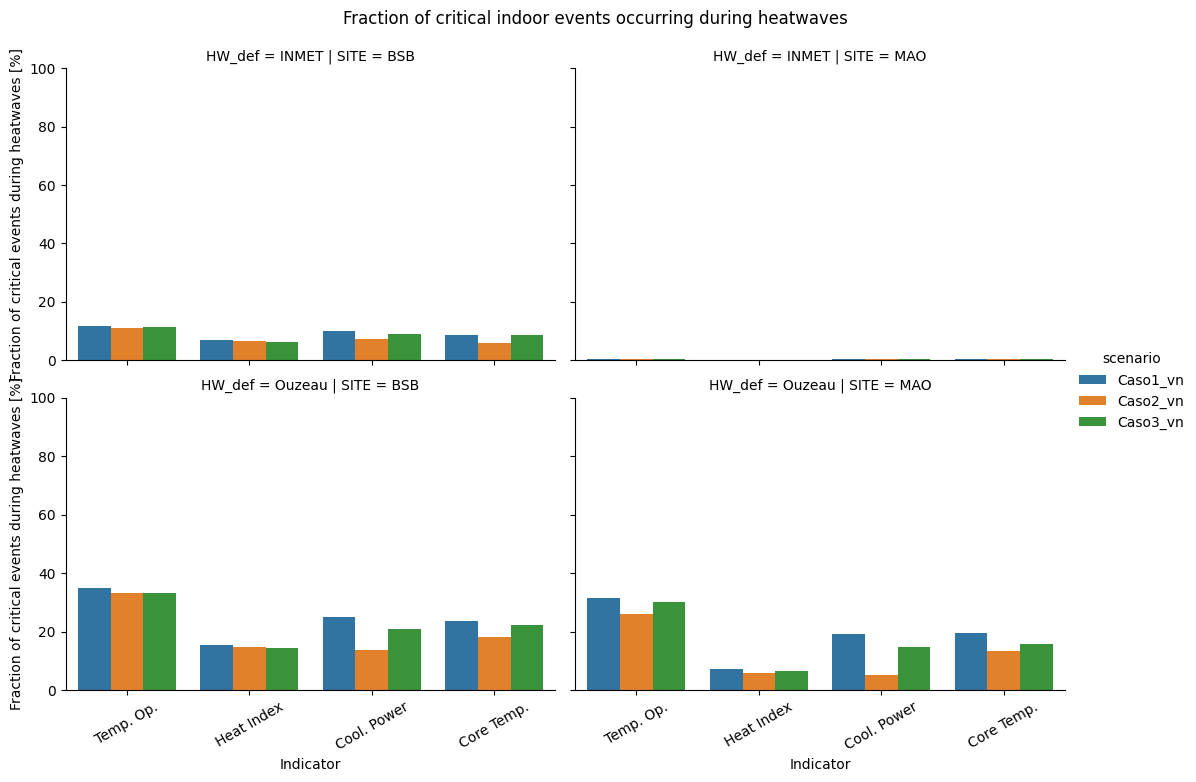

In [32]:
plot_df = frac_all.query("Indicator != 'Core_abs'")

g = sns.catplot(
    data=plot_df,
    x="Indicator",
    y="Frac_in_HW",
    hue="scenario",      # ← casos
    col="SITE",
    row="HW_def",        # ← INMET / Ouzeau
    kind="bar",
    errorbar=None,
    height=4,
    aspect=1.35
)

for ax in g.axes.flat:
    ax.tick_params(axis="x", rotation=30)
    ax.set_ylim(0, 100)

g.set_axis_labels(
    "Indicator",
    "Fraction of critical events during heatwaves [%]"
)

g.fig.subplots_adjust(bottom=0.18)

g.fig.suptitle(
    "Fraction of critical indoor events occurring during heatwaves",
    y=1.03
)

plt.show()


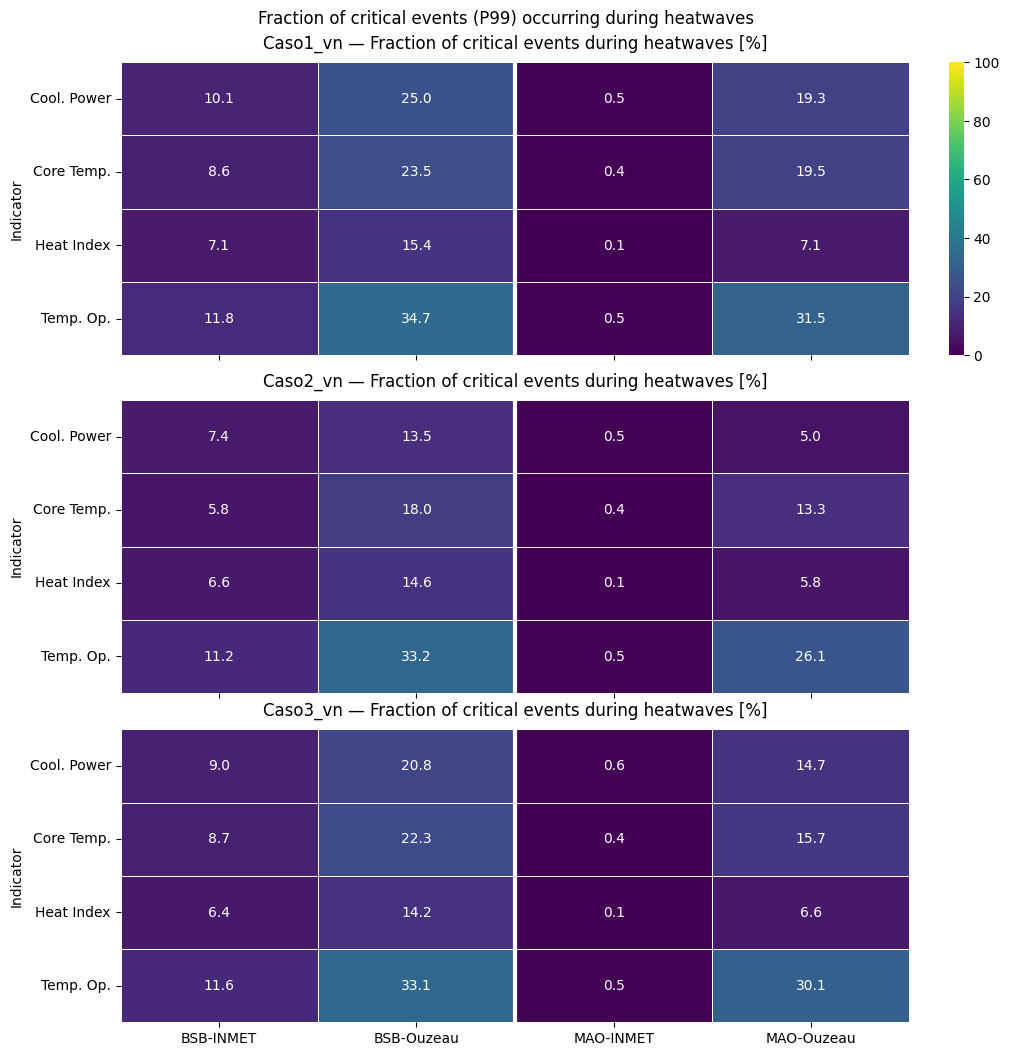

In [33]:
dfh = frac_all.query("Indicator != 'Core_abs'").copy()

# garante ordem desejada (opcional)
scenario_order = ["Caso1_vn", "Caso2_vn", "Caso3_vn"]
site_order = ["BSB", "MAO"]
hw_order = ["INMET", "Ouzeau"]

# pivot por cenário (um heatmap por caso)
pivots = {}
for scen in scenario_order:
    p = (
        dfh[dfh["scenario"] == scen]
        .pivot_table(
            index="Indicator",
            columns=["SITE", "HW_def"],
            values="Frac_in_HW"
        )
    )
    # ordena colunas para (SITE, HW_def)
    p = p.reindex(columns=pd.MultiIndex.from_product([site_order, hw_order]))
    pivots[scen] = p

# escala comum
vmin, vmax = 0, 100

fig, axes = plt.subplots(
    nrows=len(scenario_order),
    ncols=1,
    figsize=(10, 3.4 * len(scenario_order)),
    constrained_layout=True,
    sharex=True,
    sharey=True
)

if len(scenario_order) == 1:
    axes = [axes]

for ax, scen in zip(axes, scenario_order):
    pivot = pivots[scen]

    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="viridis",
        linewidths=0.5,
        linecolor="white",
        vmin=vmin,
        vmax=vmax,
        cbar=(ax is axes[0]),   # uma colorbar só
        ax=ax
    )

    ax.set_title(f"{scen} — Fraction of critical events during heatwaves [%]", pad=10)
    ax.set_xlabel("")
    ax.set_ylabel("Indicator")

    # rótulos Y legíveis
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

    # separador visual entre cidades
    sites = pivot.columns.get_level_values(0)
    for i in range(len(sites) - 1):
        if sites[i] != sites[i + 1]:
            ax.vlines(i + 1, *ax.get_ylim(), colors="white", linewidth=3)

# título geral (opcional)
fig.suptitle("Fraction of critical events (P99) occurring during heatwaves", y=1.02)

plt.show()

Correlação entre variáveis ambientais e indicadores

In [34]:
env_vars = ["ta_c", "rh_pct", "ghi_Whm2", "wind_spd_ms"]

ind_vars = {
    "Temp. Op.": "vn_DORM1_Top_C",
    "Heat Index": "vn_DORM1_HeatIndex_C",
    "Cool. Power": "ac_DORM1_Cool_P_W",
    "Core Temp.": "jos3_t_core_age30",
}

corrs = []

for (site_id, zone), df_site in fulls.items():
    for scen, g in df_site.groupby("scenario"):
        for ind_name, ind_col in ind_vars.items():
            if ind_col not in g.columns:
                continue

            for env in env_vars:
                if env not in g.columns:
                    continue

                x = g[env]
                y = g[ind_col]
                mask = x.notna() & y.notna()

                if int(mask.sum()) < 100:
                    continue

                rho, _ = spearmanr(x[mask], y[mask])

                corrs.append({
                    "SITE": site_id,
                    "ZONE": zone,
                    "scenario": scen,
                    "Indicator": ind_name,
                    "Env": env,
                    "Spearman_r": rho
                })

corr_df = pd.DataFrame(corrs)
corr_df

,SITE,ZONE,scenario,Indicator,Env,Spearman_r
0,BSB,DORM1,Caso1_vn,Temp. Op.,ta_c,0.834863
1,BSB,DORM1,Caso1_vn,Temp. Op.,rh_pct,-0.430113
2,BSB,DORM1,Caso1_vn,Temp. Op.,ghi_Whm2,0.310074
3,BSB,DORM1,Caso1_vn,Temp. Op.,wind_spd_ms,0.303487
4,BSB,DORM1,Caso1_vn,Heat Index,ta_c,0.884604
...,...,...,...,...,...,...
91,MAO,DORM1,Caso3_vn,Cool. Power,wind_spd_ms,0.420993
92,MAO,DORM1,Caso3_vn,Core Temp.,ta_c,0.643265
93,MAO,DORM1,Caso3_vn,Core Temp.,rh_pct,-0.468414
94,MAO,DORM1,Caso3_vn,Core Temp.,ghi_Whm2,0.224370


In [35]:
corr_wide = corr_df.pivot_table(
    index=["SITE","ZONE","Indicator","Env"],
    columns="scenario",
    values="Spearman_r"
).sort_index()

In [36]:
corr_wide

scenario                            Caso1_vn  Caso2_vn  Caso3_vn
SITE ZONE  Indicator   Env                                      
BSB  DORM1 Cool. Power ghi_Whm2     0.355288  0.789818  0.356864
                       rh_pct      -0.399942 -0.454931 -0.411729
                       ta_c         0.810880  0.878835  0.816737
                       wind_spd_ms  0.345337  0.528668  0.364156
           Core Temp.  ghi_Whm2     0.078252  0.376348  0.052840
                       rh_pct      -0.141996 -0.301717 -0.145255
                       ta_c         0.607249  0.815249  0.601777
                       wind_spd_ms  0.149512  0.336336  0.148158
           Heat Index  ghi_Whm2     0.380360  0.528752  0.368454
                       rh_pct      -0.412798 -0.470115 -0.409182
                       ta_c         0.884604  0.940884  0.879868
                       wind_spd_ms  0.336843  0.412938  0.335049
           Temp. Op.   ghi_Whm2     0.310074  0.545514  0.290914
                       rh_pct      -0.430113 -0.528930 -0.427810
                       ta_c         0.834863  0.940996  0.829178
                       wind_spd_ms  0.303487  0.428729  0.302018
MAO  DORM1 Cool. Power ghi_Whm2     0.459533  0.852682  0.460228
                       rh_pct      -0.640414 -0.699389 -0.633248
                       ta_c         0.762280  0.841923  0.749244
                       wind_spd_ms  0.417540  0.550536  0.420993
           Core Temp.  ghi_Whm2     0.247482  0.632050  0.224370
                       rh_pct      -0.481218 -0.659748 -0.468414
                       ta_c         0.658615  0.862276  0.643265
                       wind_spd_ms  0.275191  0.464605  0.267953
           Heat Index  ghi_Whm2     0.432771  0.579448  0.422558
                       rh_pct      -0.546619 -0.611443 -0.539951
                       ta_c         0.861957  0.916055  0.855490
                       wind_spd_ms  0.358389  0.426668  0.354598
           Temp. Op.   ghi_Whm2     0.404636  0.660759  0.386394
                       rh_pct      -0.646866 -0.741239 -0.635973
                       ta_c         0.805272  0.918430  0.792784
                       wind_spd_ms  0.377184  0.492570  0.371180

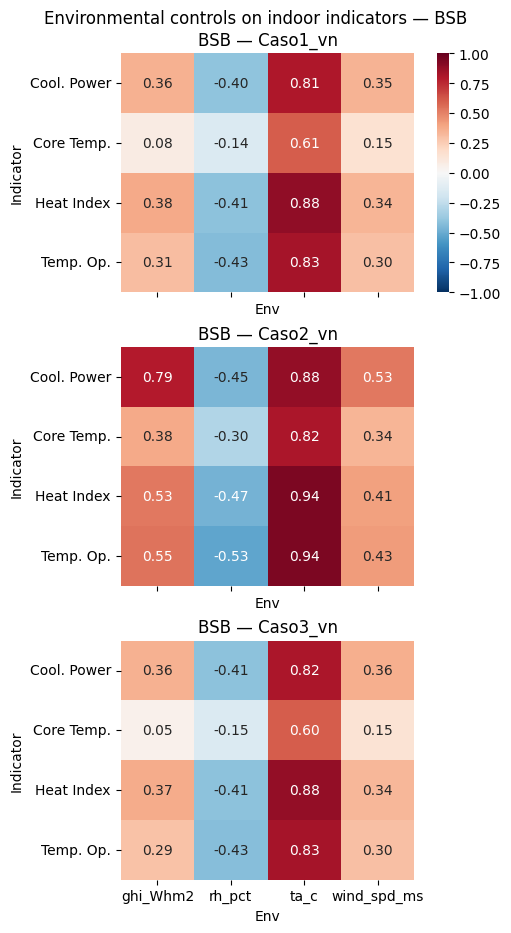

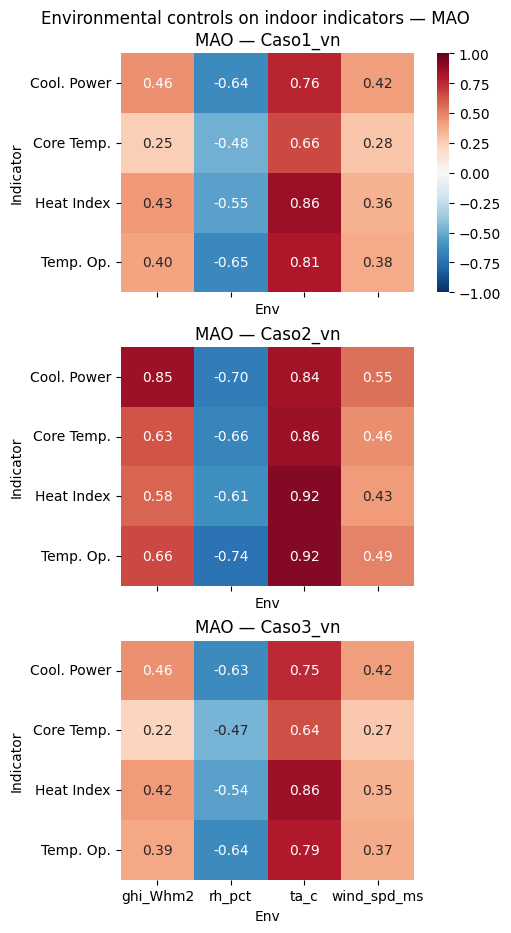

In [38]:
scenario_order = ["Caso1_vn", "Caso2_vn", "Caso3_vn"]

for site_id in corr_df["SITE"].unique():

    pivots = []
    for scen in scenario_order:
        p = (
            corr_df
            .query("SITE == @site_id and scenario == @scen")
            .pivot_table(
                index="Indicator",
                columns="Env",
                values="Spearman_r"
            )
        )
        pivots.append(p)

    fig, axes = plt.subplots(
        nrows=len(pivots),
        ncols=1,
        figsize=(5, 3 * len(pivots)),
        sharex=True,
        sharey=True,
        constrained_layout=True
    )

    for ax, p, scen in zip(axes, pivots, scenario_order):
        sns.heatmap(
            p,
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",
            center=0,
            vmin=-1, vmax=1,
            ax=ax,
            cbar=(ax is axes[0])
        )
        ax.set_title(f"{site_id} — {scen}")
        ax.set_ylabel("Indicator")

    fig.suptitle(f"Environmental controls on indoor indicators — {site_id}", y=1.02)
    plt.show()


In [45]:
sites = [("MAO","DORM1"), ("BSB","DORM1")]

xmin = min(fulls[s]["ta_c"].dropna().min() for s in sites)
xmax = max(fulls[s]["ta_c"].dropna().max() for s in sites)

ymin = min(fulls[s]["rh_pct"].dropna().min() for s in sites)
ymax = max(fulls[s]["rh_pct"].dropna().max() for s in sites)

vmin = min(fulls[s]["vn_DORM1_HeatIndex_C"].dropna().min() for s in sites)
vmax = max(fulls[s]["vn_DORM1_HeatIndex_C"].dropna().max() for s in sites)

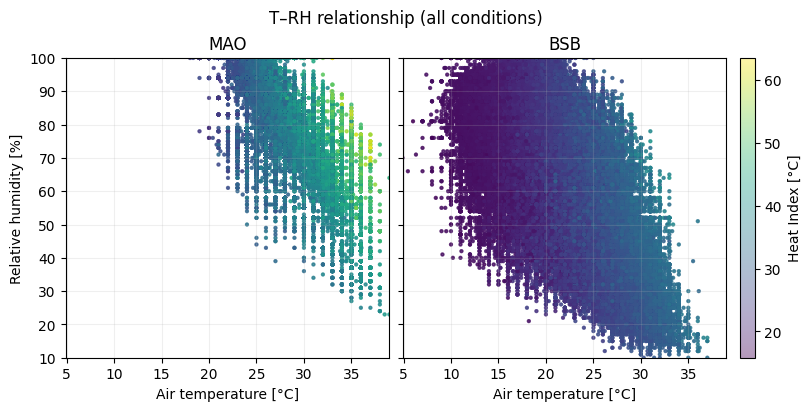

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

for ax, site in zip(axes, sites):
    full = fulls[site]

    sc = ax.scatter(
        full["ta_c"], full["rh_pct"],
        c=full["vn_DORM1_HeatIndex_C"],
        cmap="viridis",
        vmin=vmin, vmax=vmax,
        s=4, alpha=0.4
    )

    ax.set_title(site[0])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, location="right", pad=0.02, fraction=0.045)
cbar.set_label("Heat Index [°C]")

fig.suptitle("T–RH relationship (all conditions)")
plt.show()


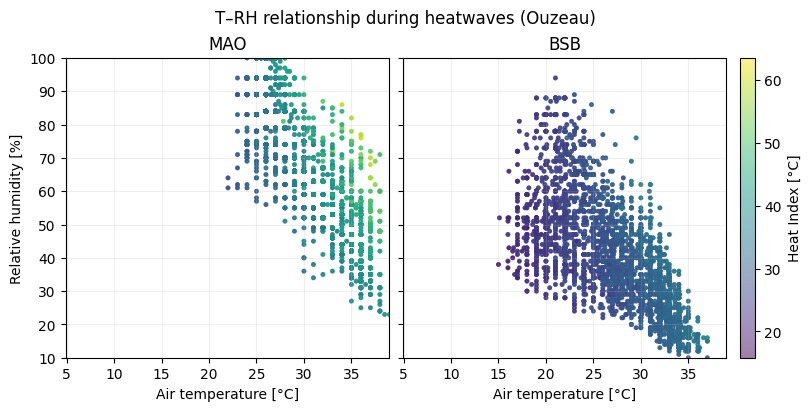

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

for ax, site in zip(axes, sites):
    full = fulls[site]
    mask = full["HW_OU_bool"]

    sc = ax.scatter(
        full.loc[mask, "ta_c"],
        full.loc[mask, "rh_pct"],
        c=full.loc[mask, "vn_DORM1_HeatIndex_C"],
        cmap="viridis",
        vmin=vmin, vmax=vmax,
        s=6, alpha=0.5
    )

    ax.set_title(site[0])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, location="right", pad=0.02, fraction=0.045)
cbar.set_label("Heat Index [°C]")

fig.suptitle("T–RH relationship during heatwaves (Ouzeau)")
plt.show()


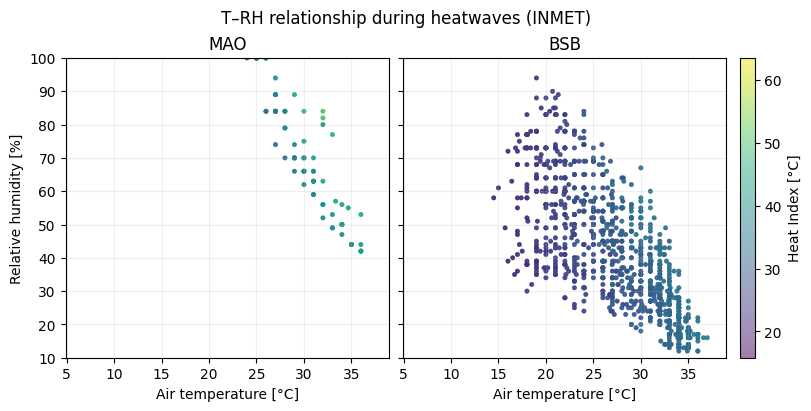

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

for ax, site in zip(axes, sites):
    full = fulls[site]
    mask = full["HW_INMET_bool"]

    sc = ax.scatter(
        full.loc[mask, "ta_c"],
        full.loc[mask, "rh_pct"],
        c=full.loc[mask, "vn_DORM1_HeatIndex_C"],
        cmap="viridis",
        vmin=vmin, vmax=vmax,
        s=6, alpha=0.5
    )

    ax.set_title(site[0])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, location="right", pad=0.02, fraction=0.045)
cbar.set_label("Heat Index [°C]")

fig.suptitle("T–RH relationship during heatwaves (INMET)")
plt.show()


In [50]:
sites = [("MAO","DORM1"), ("BSB","DORM1")]

# limites fixos de eixo
xmin = min(fulls[s]["ta_c"].min() for s in sites)
xmax = max(fulls[s]["ta_c"].max() for s in sites)

ymin = min(fulls[s]["rh_pct"].min() for s in sites)
ymax = max(fulls[s]["rh_pct"].max() for s in sites)

# limites fixos da cor (Core Temp)
vmin = min(fulls[s]["jos3_t_core_age75"].min() for s in sites)
vmax = max(fulls[s]["jos3_t_core_age75"].max() for s in sites)


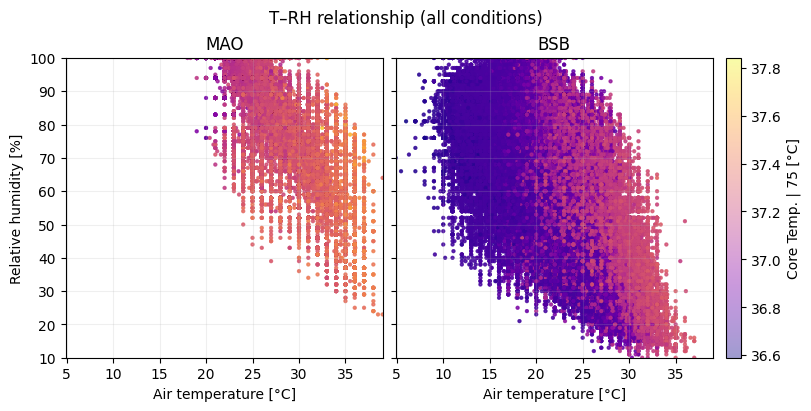

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

for ax, site in zip(axes, sites):
    full = fulls[site]

    sc = ax.scatter(
        full["ta_c"], full["rh_pct"],
        c=full["jos3_t_core_age75"],
        cmap="plasma",
        vmin=vmin, vmax=vmax,
        s=4, alpha=0.4
    )

    ax.set_title(site[0])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, location="right", pad=0.02, fraction=0.045)
cbar.set_label("Core Temp. | 75 [°C]")

fig.suptitle("T–RH relationship (all conditions)")
plt.show()


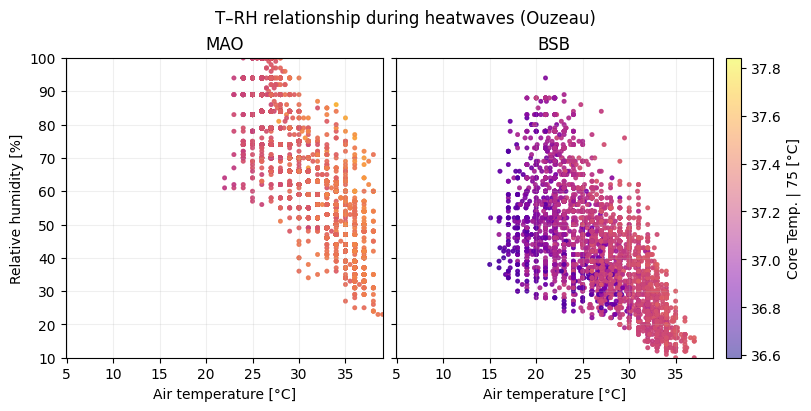

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

for ax, site in zip(axes, sites):
    full = fulls[site]
    mask = full["HW_OU_bool"]

    sc = ax.scatter(
        full.loc[mask, "ta_c"],
        full.loc[mask, "rh_pct"],
        c=full.loc[mask, "jos3_t_core_age75"],
        cmap="plasma",
        vmin=vmin, vmax=vmax,
        s=6, alpha=0.5
    )

    ax.set_title(site[0])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, location="right", pad=0.02, fraction=0.045)
cbar.set_label("Core Temp. | 75 [°C]")

fig.suptitle("T–RH relationship during heatwaves (Ouzeau)")
plt.show()


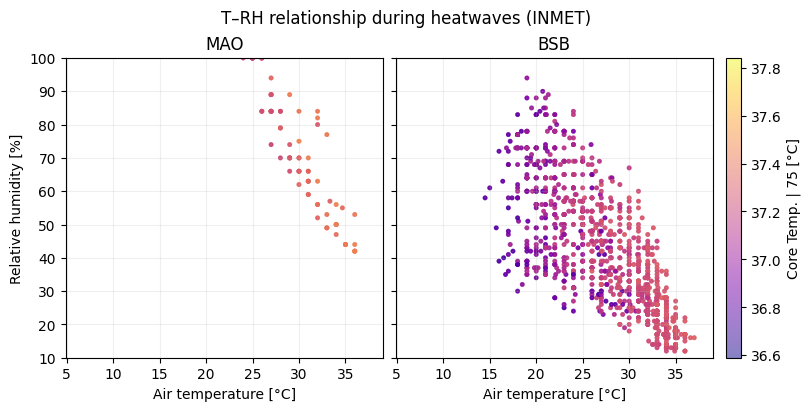

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)

for ax, site in zip(axes, sites):
    full = fulls[site]
    mask = full["HW_INMET_bool"]

    sc = ax.scatter(
        full.loc[mask, "ta_c"],
        full.loc[mask, "rh_pct"],
        c=full.loc[mask, "jos3_t_core_age75"],
        cmap="plasma",
        vmin=vmin, vmax=vmax,
        s=6, alpha=0.5
    )

    ax.set_title(site[0])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, location="right", pad=0.02, fraction=0.045)
cbar.set_label("Core Temp. | 75 [°C]")

fig.suptitle("T–RH relationship during heatwaves (INMET)")
plt.show()


In [54]:
for site_id, full in fulls.items():
    if (
        "jos3_t_core_age75" in full.columns
        and "jos3_t_core_age30" in full.columns
    ):
        full["delta_core_75_30"] = (
            full["jos3_t_core_age75"] - full["jos3_t_core_age30"]
        )
    else:
        print(f"[WARN] {site_id}: colunas de core faltando")


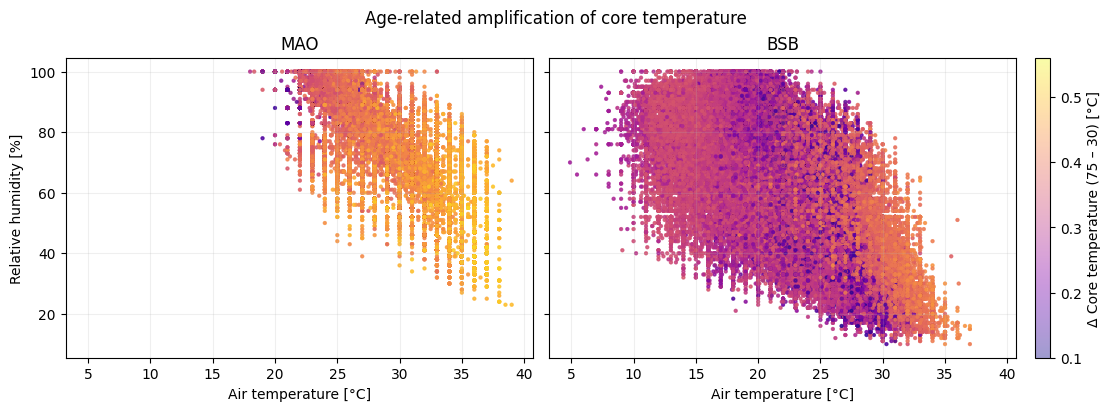

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True, constrained_layout=True)

sites = [("MAO","DORM1"), ("BSB","DORM1")]

vmin = min(fulls[s]["delta_core_75_30"].min() for s in sites)
vmax = max(fulls[s]["delta_core_75_30"].max() for s in sites)

for ax, site in zip(axes, sites):
    full = fulls[site]
    sc = ax.scatter(
        full["ta_c"], full["rh_pct"],
        c=full["delta_core_75_30"],
        cmap="plasma",
        vmin=vmin, vmax=vmax,
        s=4, alpha=0.4
    )
    ax.set_title(site[0])
    ax.set_xlabel("Air temperature [°C]")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Relative humidity [%]")

cbar = fig.colorbar(sc, ax=axes, pad=0.02)
cbar.set_label("Δ Core temperature (75 – 30) [°C]")

fig.suptitle("Age-related amplification of core temperature")
plt.show()


Core_abs isolado

In [56]:
if isinstance(rr_all["SITE"].iloc[0], tuple):
    rr_all[["SITE_ID", "ZONE"]] = pd.DataFrame(rr_all["SITE"].tolist(), index=rr_all.index)
else:
    rr_all["SITE_ID"] = rr_all["SITE"]
    rr_all["ZONE"] = "DORM1"  # ou deixe vazio

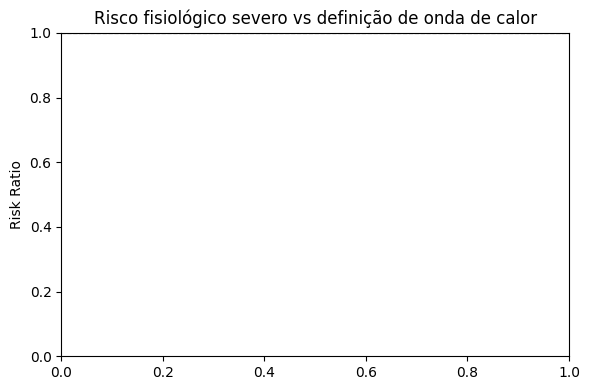

In [57]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=rr_all.query("Indicator == 'Core_abs'"),
    x="SITE_ID",
    y="Risk_Ratio",
    hue="HW_def"
)
plt.axhline(1, color="k", ls="--", lw=0.8)
plt.title("Risco fisiológico severo vs definição de onda de calor")
plt.ylabel("Risk Ratio")
plt.tight_layout()
plt.show()


Panorama temporal dos dados

In [61]:
print("Período:", full.index.min(), "→", full.index.max())
print("Registros:", len(full))

# distribuição de anos
annual_count = full.resample("YE")["HW_INMET_bool"].count()
print("anos simulados:", annual_count.shape[0])


Período: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
Registros: 867240
anos simulados: 34


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3393072537.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  full["HW_INMET_bool"].resample("Y").sum().plot(label="INMET", lw=2)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3393072537.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  full["HW_OU_bool"].resample("Y").sum().plot(label="Ouzeau", lw=2)


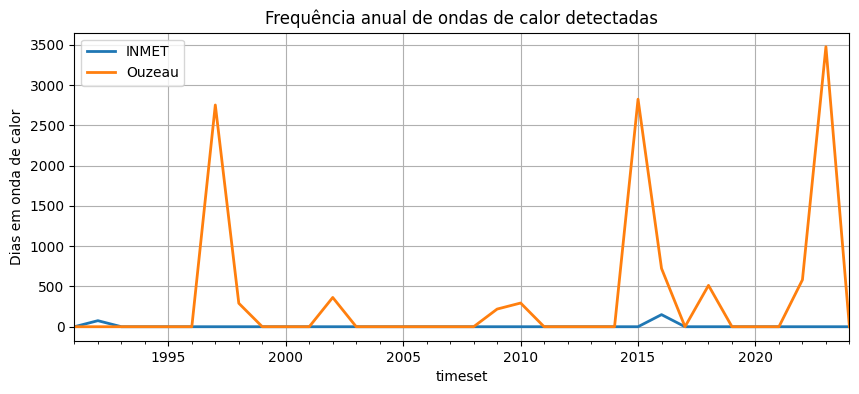

In [ ]:
plt.figure(figsize=(10,4))
full["HW_INMET_bool"].resample("Y").sum().plot(label="INMET", lw=2)
full["HW_OU_bool"].resample("Y").sum().plot(label="Ouzeau", lw=2)
plt.ylabel("Dias em onda de calor")
plt.title("Frequência anual de ondas de calor detectadas")
plt.legend(); plt.grid(True)

Intensidade térmica e comparação entre métodos

In [64]:
cols_hw = ["HW_INMET_bool", "HW_OU_bool"]
AGE = "age30"  # ou "age75"

# 1) Energia total (kWh) — se existir
full["ac_total_cool_kWh"] = (
    full.get("ac_SALA_Cool_E_kWh", 0.0) +
    full.get("ac_DORM1_Cool_E_kWh", 0.0) +
    full.get("ac_DORM2_Cool_E_kWh", 0.0)
)

# 2) Potência total instantânea (W)
full["ac_total_cool_W"] = (
    full.get("ac_SALA_Cool_P_W", 0.0) +
    full.get("ac_DORM1_Cool_P_W", 0.0) +
    full.get("ac_DORM2_Cool_P_W", 0.0)
)

# 3) Dataframe base (com idade explícita)
df_hw = full[
    [
        "scenario",
        "vn_DORM1_Top_C",
        "vn_DORM1_HeatIndex_C",
        "vn_DORM1_HumidityIndex",
        f"jos3_t_skin_mean_{AGE}",
        f"jos3_t_core_{AGE}",
        "ac_total_cool_W",
    ] + cols_hw
].copy()

# garantir boolean nos HW flags (evita NaNs virarem grupo separado)
for c in cols_hw:
    df_hw[c] = df_hw[c].fillna(False).astype(bool)

# 4) Agrupar e pegar médias: por scenario e combinação de HWs
summary = (
    df_hw
    .groupby(["scenario"] + cols_hw)
    .mean(numeric_only=True)
    .round(1)
)

# 5) Renomear combinações de HW
mapping = {
    (False, False): "No heatwave",
    (True,  False): "INMET only",
    (False, True):  "Ouzeau only",
    (True,  True):  "Both"
}

# O index é MultiIndex: (scenario, HW_INMET_bool, HW_OU_bool)
# vamos mapear só a parte HW e manter scenario
summary = summary.reset_index()
summary["HW_combo"] = list(zip(summary["HW_INMET_bool"], summary["HW_OU_bool"]))
summary["HW_combo"] = summary["HW_combo"].map(mapping)

# 6) Reordenar categorias
order = ["No heatwave", "INMET only", "Ouzeau only", "Both"]
summary["HW_combo"] = pd.Categorical(summary["HW_combo"], categories=order, ordered=True)

summary = (
    summary
    .drop(columns=["HW_INMET_bool", "HW_OU_bool"])
    .sort_values(["scenario", "HW_combo"])
    .set_index(["scenario", "HW_combo"])
)

summary


vn_DORM1_Top_C  vn_DORM1_HeatIndex_C  \
scenario HW_combo                                            
Caso1_vn No heatwave            30.4                  34.5   
         INMET only             32.8                  40.7   
         Ouzeau only            34.0                  39.3   
         Both                   34.2                  38.9   
Caso2_vn No heatwave            29.8                  33.8   
         INMET only             32.4                  40.2   
         Ouzeau only            32.9                  38.2   
         Both                   33.1                  37.8   
Caso3_vn No heatwave            30.6                  34.8   
         INMET only             33.1                  41.0   
         Ouzeau only            34.2                  39.4   
         Both                   34.4                  39.0   

                      vn_DORM1_HumidityIndex  jos3_t_skin_mean_age30  \
scenario HW_combo                                                      
Caso1_vn No heatwave                    40.9                    35.5   
         INMET only                     45.5                    35.7   
         Ouzeau only                    44.1                    35.8   
         Both                           43.9                    35.8   
Caso2_vn No heatwave                    40.4                    35.4   
         INMET only                     45.3                    35.6   
         Ouzeau only                    43.3                    35.6   
         Both                           43.1                    35.7   
Caso3_vn No heatwave                    41.0                    35.5   
         INMET only                     45.7                    35.8   
         Ouzeau only                    44.2                    35.8   
         Both                           44.0                    35.8   

                      jos3_t_core_age30  ac_total_cool_W  
scenario HW_combo                                         
Caso1_vn No heatwave               36.8           2647.0  
         INMET only                36.9           3465.8  
         Ouzeau only               36.9           3723.1  
         Both                      36.9           3839.5  
Caso2_vn No heatwave               36.8           1622.8  
         INMET only                36.9           2199.8  
         Ouzeau only               36.9           2055.0  
         Both                      36.9           2155.2  
Caso3_vn No heatwave               36.8           2496.9  
         INMET only                36.9           3284.9  
         Ouzeau only               36.9           3404.9  
         Both                      36.9           3498.2

In [65]:
summary_wide = summary.reset_index().pivot_table(
    index="HW_combo",
    columns="scenario",
    values=["vn_DORM1_Top_C", "vn_DORM1_HeatIndex_C", f"jos3_t_core_{AGE}", "ac_total_cool_W"],
)
summary_wide


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\211299566.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summary_wide = summary.reset_index().pivot_table(


ac_total_cool_W                   jos3_t_core_age30           \
scenario           Caso1_vn Caso2_vn Caso3_vn          Caso1_vn Caso2_vn   
HW_combo                                                                   
No heatwave          2647.0   1622.8   2496.9              36.8     36.8   
INMET only           3465.8   2199.8   3284.9              36.9     36.9   
Ouzeau only          3723.1   2055.0   3404.9              36.9     36.9   
Both                 3839.5   2155.2   3498.2              36.9     36.9   

                     vn_DORM1_HeatIndex_C                   vn_DORM1_Top_C  \
scenario    Caso3_vn             Caso1_vn Caso2_vn Caso3_vn       Caso1_vn   
HW_combo                                                                     
No heatwave     36.8                 34.5     33.8     34.8           30.4   
INMET only      36.9                 40.7     40.2     41.0           32.8   
Ouzeau only     36.9                 39.3     38.2     39.4           34.0   
Both            36.9                 38.9     37.8     39.0           34.2   

                               
scenario    Caso2_vn Caso3_vn  
HW_combo                       
No heatwave     29.8     30.6  
INMET only      32.4     33.1  
Ouzeau only     32.9     34.2  
Both            33.1     34.4

In [66]:
cols_hw = ["HW_INMET_bool", "HW_OU_bool"]
AGE = "age30"  # ou "age75"

# 1) Energia total (kWh)
full["ac_total_cool_kWh"] = (
    full.get("ac_SALA_Cool_E_kWh", 0.0) +
    full.get("ac_DORM1_Cool_E_kWh", 0.0) +
    full.get("ac_DORM2_Cool_E_kWh", 0.0)
)

# 2) Potência total instantânea (W)
full["ac_total_cool_W"] = (
    full.get("ac_SALA_Cool_P_W", 0.0) +
    full.get("ac_DORM1_Cool_P_W", 0.0) +
    full.get("ac_DORM2_Cool_P_W", 0.0)
)

# 3) Dataframe base (idade explícita + scenario)
df_hw = full[
    [
        "scenario",
        "vn_DORM1_Top_C",
        "vn_DORM1_HeatIndex_C",
        "vn_DORM1_HumidityIndex",
        f"jos3_t_skin_mean_{AGE}",
        f"jos3_t_core_{AGE}",
        "ac_total_cool_W",
    ] + cols_hw
].copy()

# flags HW como boolean
for c in cols_hw:
    df_hw[c] = df_hw[c].fillna(False).astype(bool)

# 4) Agrupar e pegar máximos (por scenario e combinação HW)
summary = (
    df_hw
    .groupby(["scenario"] + cols_hw)
    .max(numeric_only=True)
    .round(1)
)

# 5) Renomear combinações de HW (mantendo scenario)
mapping = {
    (False, False): "No heatwave",
    (True,  False): "INMET only",
    (False, True):  "Ouzeau only",
    (True,  True):  "Both"
}

summary = summary.reset_index()
summary["HW_combo"] = list(zip(summary["HW_INMET_bool"], summary["HW_OU_bool"]))
summary["HW_combo"] = summary["HW_combo"].map(mapping)

# 6) Reordenar categorias
order = ["No heatwave", "INMET only", "Ouzeau only", "Both"]
summary["HW_combo"] = pd.Categorical(summary["HW_combo"], categories=order, ordered=True)

summary = (
    summary
    .drop(columns=["HW_INMET_bool", "HW_OU_bool"])
    .sort_values(["scenario", "HW_combo"])
    .set_index(["scenario", "HW_combo"])
)

summary


vn_DORM1_Top_C  vn_DORM1_HeatIndex_C  \
scenario HW_combo                                            
Caso1_vn No heatwave            38.4                  63.0   
         INMET only             36.7                  51.1   
         Ouzeau only            39.1                  60.2   
         Both                   38.0                  43.3   
Caso2_vn No heatwave            38.3                  63.2   
         INMET only             37.0                  49.3   
         Ouzeau only            38.5                  60.4   
         Both                   37.2                  42.4   
Caso3_vn No heatwave            39.0                  63.5   
         INMET only             37.3                  51.7   
         Ouzeau only            39.5                  60.6   
         Both                   38.4                  43.6   

                      vn_DORM1_HumidityIndex  jos3_t_skin_mean_age30  \
scenario HW_combo                                                      
Caso1_vn No heatwave                    58.9                    36.8   
         INMET only                     52.2                    36.1   
         Ouzeau only                    57.7                    36.8   
         Both                           47.3                    36.0   
Caso2_vn No heatwave                    59.0                    36.6   
         INMET only                     51.1                    36.0   
         Ouzeau only                    57.8                    36.3   
         Both                           46.6                    35.9   
Caso3_vn No heatwave                    59.3                    37.0   
         INMET only                     52.7                    36.3   
         Ouzeau only                    58.0                    37.0   
         Both                           47.5                    36.0   

                      jos3_t_core_age30  ac_total_cool_W  
scenario HW_combo                                         
Caso1_vn No heatwave               37.3           6137.0  
         INMET only                37.0           5524.1  
         Ouzeau only               37.3           6353.2  
         Both                      36.9           5809.6  
Caso2_vn No heatwave               37.3           3771.1  
         INMET only                37.0           3421.4  
         Ouzeau only               37.1           3759.5  
         Both                      36.9           3341.3  
Caso3_vn No heatwave               37.5           5778.5  
         INMET only                37.1           5279.4  
         Ouzeau only               37.5           5915.1  
         Both                      37.0           5368.9

In [67]:
summary_wide = summary.reset_index().pivot_table(
    index="HW_combo",
    columns="scenario",
    values=["vn_DORM1_Top_C", "vn_DORM1_HeatIndex_C", f"jos3_t_core_{AGE}", "ac_total_cool_W"],
)
summary_wide

C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2630887568.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summary_wide = summary.reset_index().pivot_table(


ac_total_cool_W                   jos3_t_core_age30           \
scenario           Caso1_vn Caso2_vn Caso3_vn          Caso1_vn Caso2_vn   
HW_combo                                                                   
No heatwave          6137.0   3771.1   5778.5              37.3     37.3   
INMET only           5524.1   3421.4   5279.4              37.0     37.0   
Ouzeau only          6353.2   3759.5   5915.1              37.3     37.1   
Both                 5809.6   3341.3   5368.9              36.9     36.9   

                     vn_DORM1_HeatIndex_C                   vn_DORM1_Top_C  \
scenario    Caso3_vn             Caso1_vn Caso2_vn Caso3_vn       Caso1_vn   
HW_combo                                                                     
No heatwave     37.5                 63.0     63.2     63.5           38.4   
INMET only      37.1                 51.1     49.3     51.7           36.7   
Ouzeau only     37.5                 60.2     60.4     60.6           39.1   
Both            37.0                 43.3     42.4     43.6           38.0   

                               
scenario    Caso2_vn Caso3_vn  
HW_combo                       
No heatwave     38.3     39.0  
INMET only      37.0     37.3  
Ouzeau only     38.5     39.5  
Both            37.2     38.4

Comparativo direto entre métodos (INMET vs Ouzeau)

In [72]:
for scenario, g in full.groupby("scenario"):
    print(f"\n=== {scenario} ===")

    cross = pd.crosstab(g["HW_INMET_bool"], g["HW_OU_bool"])
    print(cross)


=== Caso1_vn ===
HW_OU_bool      False  True 
HW_INMET_bool               
False          285044   3961
True               25     50

=== Caso2_vn ===
HW_OU_bool      False  True 
HW_INMET_bool               
False          285044   3961
True               25     50

=== Caso3_vn ===
HW_OU_bool      False  True 
HW_INMET_bool               
False          285044   3961
True               25     50


In [73]:
for scenario, g in full.groupby("scenario"):
    print(f"\n=== {scenario} ===")

    both = g.loc[g["HW_INMET_bool"] & g["HW_OU_bool"]]

    n_days_both = (
        both
        .resample("D")
        .size()
        .gt(0)
        .sum()
    )

    print("Dias detectados por ambos:", n_days_both)


=== Caso1_vn ===
Dias detectados por ambos: 4

=== Caso2_vn ===
Dias detectados por ambos: 4

=== Caso3_vn ===
Dias detectados por ambos: 4


Resposta fisiológica (JOS-3) em ondas de calor

In [74]:
AGE = "age30"  # ou "age75"
core_col = f"jos3_t_core_{AGE}"
skin_col = f"jos3_t_skin_mean_{AGE}"

cols = [core_col, skin_col, "ta_c"]

# INMET events
by_event_inmet = (
    full
    .dropna(subset=["INMET_hw_id"])
    .groupby(["scenario", "INMET_hw_id"])[cols]
    .agg(["mean", "max"])
    .round(2)
)

display(by_event_inmet)

# Ouzeau events
by_event_ouz = (
    full
    .dropna(subset=["OUZ_hw_id"])
    .groupby(["scenario", "OUZ_hw_id"])[cols]
    .agg(["mean", "max"])
    .round(2)
)

display(by_event_ouz)


jos3_t_core_age30         \
                                             mean    max   
scenario INMET_hw_id                                       
Caso1_vn MAO-INMET-19920201-001             36.90  37.05   
         MAO-INMET-20160110-001             36.89  36.95   
         MAO-INMET-20160117-002             36.91  36.97   
Caso2_vn MAO-INMET-19920201-001             36.88  37.01   
         MAO-INMET-20160110-001             36.86  36.92   
         MAO-INMET-20160117-002             36.88  36.94   
Caso3_vn MAO-INMET-19920201-001             36.92  37.16   
         MAO-INMET-20160110-001             36.89  36.97   
         MAO-INMET-20160117-002             36.91  36.99   

                                jos3_t_skin_mean_age30          ta_c        
                                                  mean    max   mean   max  
scenario INMET_hw_id                                                        
Caso1_vn MAO-INMET-19920201-001                  35.74  36.21  29.71  36.0  
         MAO-INMET-20160110-001                  35.75  35.96  30.83  36.0  
         MAO-INMET-20160117-002                  35.82  36.02  31.35  37.0  
Caso2_vn MAO-INMET-19920201-001                  35.67  36.10  29.71  36.0  
         MAO-INMET-20160110-001                  35.63  35.90  30.83  36.0  
         MAO-INMET-20160117-002                  35.71  35.96  31.35  37.0  
Caso3_vn MAO-INMET-19920201-001                  35.80  36.47  29.71  36.0  
         MAO-INMET-20160110-001                  35.76  36.01  30.83  36.0  
         MAO-INMET-20160117-002                  35.84  36.07  31.35  37.0

jos3_t_core_age30         \
                                              mean    max   
scenario OUZ_hw_id                                          
Caso1_vn MAO-Ouzeau-19970911-001             36.88  37.07   
         MAO-Ouzeau-19970930-002             36.88  36.94   
         MAO-Ouzeau-19971012-003             36.92  37.07   
         MAO-Ouzeau-19971021-004             36.91  36.98   
         MAO-Ouzeau-19971025-005             36.93  37.34   
...                                            ...    ...   
Caso3_vn MAO-Ouzeau-20230901-002             36.88  36.96   
         MAO-Ouzeau-20230909-003             36.89  36.94   
         MAO-Ouzeau-20230929-004             36.90  36.99   
         MAO-Ouzeau-20231026-005             36.91  37.00   
         MAO-Ouzeau-20231110-006             36.91  36.98   

                                 jos3_t_skin_mean_age30          ta_c        
                                                   mean    max   mean   max  
scenario OUZ_hw_id                                                           
Caso1_vn MAO-Ouzeau-19970911-001                  35.72  36.26  30.27  38.0  
         MAO-Ouzeau-19970930-002                  35.72  35.94  29.74  38.0  
         MAO-Ouzeau-19971012-003                  35.85  36.27  30.61  38.0  
         MAO-Ouzeau-19971021-004                  35.81  36.03  29.65  38.0  
         MAO-Ouzeau-19971025-005                  35.85  36.80  30.68  38.0  
...                                                 ...    ...    ...   ...  
Caso3_vn MAO-Ouzeau-20230901-002                  35.73  35.97  29.93  37.0  
         MAO-Ouzeau-20230909-003                  35.75  35.95  30.26  37.0  
         MAO-Ouzeau-20230929-004                  35.81  36.08  30.54  38.0  
         MAO-Ouzeau-20231026-005                  35.81  36.10  30.06  37.0  
         MAO-Ouzeau-20231110-006                  35.81  36.07  30.22  37.0  

[81 rows x 6 columns]

In [76]:
by_event_inmet_case = (
    full
    .dropna(subset=["INMET_hw_id"])
    .groupby(["CASE", "INMET_hw_id"])[cols]
    .agg(["mean", "max"])
    .round(2)
)
display(by_event_inmet_case)

jos3_t_core_age30        jos3_t_skin_mean_age30  \
                                          mean    max                   mean   
CASE  INMET_hw_id                                                              
Caso1 MAO-INMET-19920201-001             36.90  37.05                  35.74   
      MAO-INMET-20160110-001             36.89  36.95                  35.75   
      MAO-INMET-20160117-002             36.91  36.97                  35.82   
Caso2 MAO-INMET-19920201-001             36.88  37.01                  35.67   
      MAO-INMET-20160110-001             36.86  36.92                  35.63   
      MAO-INMET-20160117-002             36.88  36.94                  35.71   
Caso3 MAO-INMET-19920201-001             36.92  37.16                  35.80   
      MAO-INMET-20160110-001             36.89  36.97                  35.76   
      MAO-INMET-20160117-002             36.91  36.99                  35.84   

                                      ta_c        
                                max   mean   max  
CASE  INMET_hw_id                                 
Caso1 MAO-INMET-19920201-001  36.21  29.71  36.0  
      MAO-INMET-20160110-001  35.96  30.83  36.0  
      MAO-INMET-20160117-002  36.02  31.35  37.0  
Caso2 MAO-INMET-19920201-001  36.10  29.71  36.0  
      MAO-INMET-20160110-001  35.90  30.83  36.0  
      MAO-INMET-20160117-002  35.96  31.35  37.0  
Caso3 MAO-INMET-19920201-001  36.47  29.71  36.0  
      MAO-INMET-20160110-001  36.01  30.83  36.0  
      MAO-INMET-20160117-002  36.07  31.35  37.0

Coocorrência de indicadores internos em overheating

In [77]:
AGE = "age30"  # ou "age75"

internal_vars = [
    "vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    f"jos3_t_skin_mean_{AGE}",
    f"jos3_t_core_{AGE}",
    "ac_total_cool_W",   # só se existir
]

frac_extreme = 0.01  # top 1%

thresholds = {}   # {(scenario, col): thr}
counts = []       # para checar quantas horas marcadas

for scen in full["scenario"].unique():
    mask_s = full["scenario"] == scen
    N = int(mask_s.sum())
    n_ext = max(1, int(round(frac_extreme * N)))

    print(f"{scen}: linhas={N} | horas extremas por variável={n_ext}")

    for col in internal_vars:
        if col not in full.columns:
            continue

        flag_col = f"flag_extreme_{col}"  # você pode incluir _{scen} se quiser
        # zera apenas dentro do cenário
        full.loc[mask_s, flag_col] = False

        s = full.loc[mask_s, col].astype(float)

        # pega os índices (labels) das n_ext maiores LINHAS desse cenário
        # como index é timeset repetido, vamos pegar a posição via nlargest e usar máscara por linha
        top = s.nlargest(n_ext)
        thr_val = float(top.min())
        thresholds[(scen, col)] = thr_val

        # marca como True onde valor >= threshold dentro do cenário
        # (pode dar um pouco mais de n_ext se houver empates no limiar; ok e esperado)
        full.loc[mask_s, flag_col] = s >= thr_val

        counts.append({
            "scenario": scen,
            "variable": col,
            "hours_extreme": int(full.loc[mask_s, flag_col].sum()),
            "threshold": thr_val
        })

counts_df = pd.DataFrame(counts)
counts_df


Caso1_vn: linhas=289080 | horas extremas por variável=2891
Caso2_vn: linhas=289080 | horas extremas por variável=2891
Caso3_vn: linhas=289080 | horas extremas por variável=2891


,scenario,variable,hours_extreme,threshold
0,Caso1_vn,vn_DORM1_Top_C,2891,36.204492
1,Caso1_vn,vn_DORM1_HeatIndex_C,2891,46.795734
2,Caso1_vn,vn_DORM1_HumidityIndex,2891,49.641669
3,Caso1_vn,jos3_t_skin_mean_age30,3187,35.900000
4,Caso1_vn,jos3_t_core_age30,3672,36.930000
5,Caso1_vn,ac_total_cool_W,2891,5069.603239
6,Caso2_vn,vn_DORM1_Top_C,2891,35.750986
7,Caso2_vn,vn_DORM1_HeatIndex_C,2891,46.611525
8,Caso2_vn,vn_DORM1_HumidityIndex,2891,49.531444
9,Caso2_vn,jos3_t_skin_mean_age30,2942,35.850000


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\74140534.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gb = g[flags].fillna(False).astype(bool)


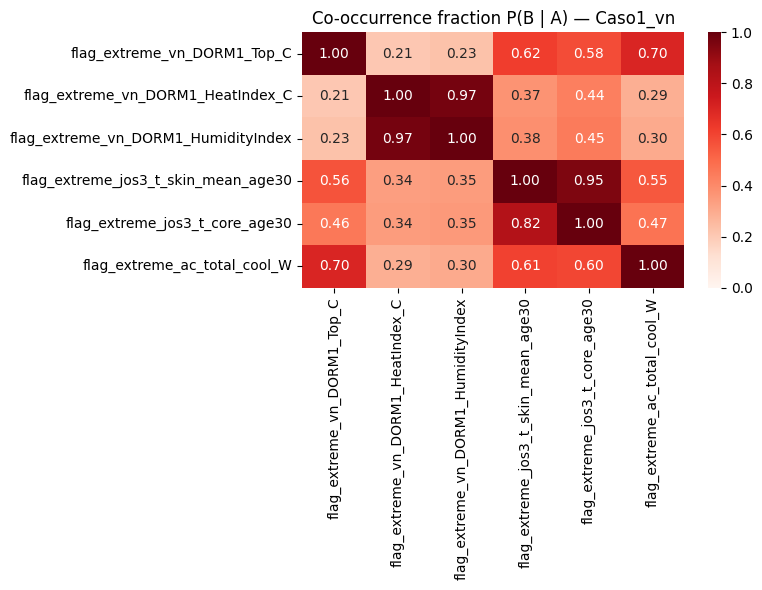

C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\74140534.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gb = g[flags].fillna(False).astype(bool)


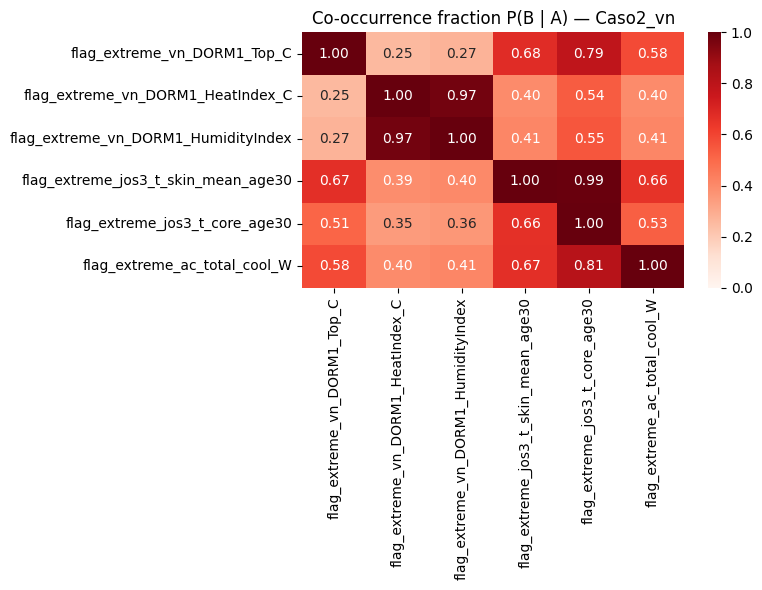

C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\74140534.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gb = g[flags].fillna(False).astype(bool)


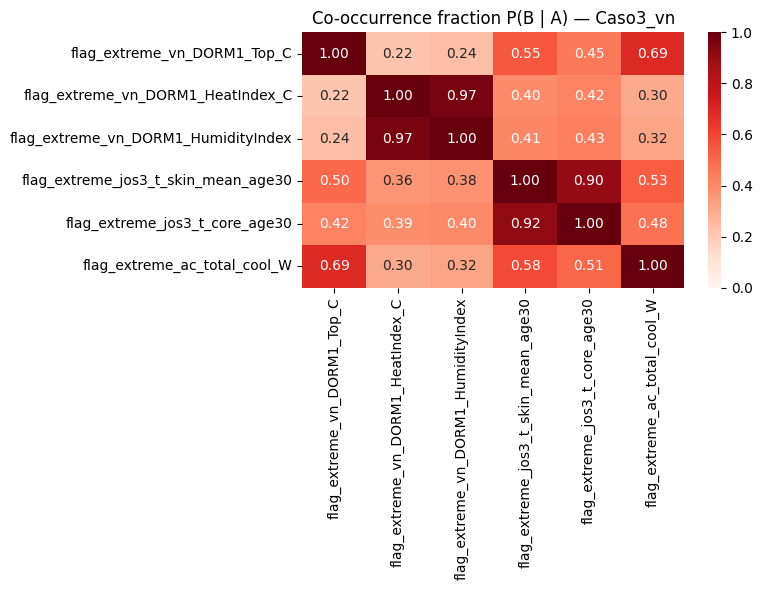

In [78]:
flags = [f"flag_extreme_{col}" for col in internal_vars if f"flag_extreme_{col}" in full.columns]

for scen, g in full.groupby("scenario"):
    gb = g[flags].fillna(False).astype(bool)

    frac_matrix = pd.DataFrame(np.nan, index=flags, columns=flags, dtype=float)

    for a in flags:
        denom = gb[a].sum()
        for b in flags:
            frac_matrix.loc[a, b] = (gb[a] & gb[b]).sum() / denom if denom > 0 else np.nan

    plt.figure(figsize=(8, 6))
    sns.heatmap(frac_matrix, annot=True, fmt=".2f", cmap="Reds", vmin=0, vmax=1)
    plt.title(f"Co-occurrence fraction P(B | A) — {scen}")
    plt.tight_layout()
    plt.show()


In [79]:
import itertools

rows = []

for scen, g in full.groupby("scenario"):

    # garantir boolean
    gb = g[flags].fillna(False).astype(bool)

    for a, b in itertools.combinations(flags, 2):
        A = gb[a]
        B = gb[b]

        nA = A.sum()
        nB = B.sum()
        inter = (A & B).sum()

        rows.append({
            "scenario": scen,
            "A": a,
            "B": b,
            "intersection_hours": int(inter),
            "% of A": round(100 * inter / nA, 2) if nA > 0 else np.nan,
            "% of B": round(100 * inter / nB, 2) if nB > 0 else np.nan,
        })

overlaps_df = (
    pd.DataFrame(rows)
    .sort_values(["scenario", "intersection_hours"], ascending=[True, False])
    .reset_index(drop=True)
)

overlaps_df


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2928365324.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gb = g[flags].fillna(False).astype(bool)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2928365324.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gb = g[flags].fillna(False).astype(bool)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2928365324.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

,scenario,A,B,intersection_hours,% of A,% of B
0,Caso1_vn,flag_extreme_jos3_t_skin_mean_age30,flag_extreme_jos3_t_core_age30,3028,95.01,82.46
1,Caso1_vn,flag_extreme_vn_DORM1_HeatIndex_C,flag_extreme_vn_DORM1_HumidityIndex,2810,97.20,97.20
2,Caso1_vn,flag_extreme_vn_DORM1_Top_C,flag_extreme_ac_total_cool_W,2029,70.18,70.18
3,Caso1_vn,flag_extreme_vn_DORM1_Top_C,flag_extreme_jos3_t_skin_mean_age30,1790,61.92,56.17
4,Caso1_vn,flag_extreme_jos3_t_skin_mean_age30,flag_extreme_ac_total_cool_W,1754,55.04,60.67
5,Caso1_vn,flag_extreme_jos3_t_core_age30,flag_extreme_ac_total_cool_W,1727,47.03,59.74
6,Caso1_vn,flag_extreme_vn_DORM1_Top_C,flag_extreme_jos3_t_core_age30,1675,57.94,45.62
7,Caso1_vn,flag_extreme_vn_DORM1_HumidityIndex,flag_extreme_jos3_t_core_age30,1295,44.79,35.27
8,Caso1_vn,flag_extreme_vn_DORM1_HeatIndex_C,flag_extreme_jos3_t_core_age30,1264,43.72,34.42
9,Caso1_vn,flag_extreme_vn_DORM1_HumidityIndex,flag_extreme_jos3_t_skin_mean_age30,1107,38.29,34.73


Porcentagem de horas com extremos internos durante HW

In [81]:
cols_ext = [
    "flag_extreme_vn_DORM1_Top_C_p99",
    "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "flag_extreme_vn_DORM1_HumidityIndex_p99",
    "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "flag_extreme_jos3_t_core_age30_p99",
    "flag_extreme_jos3_t_skin_mean_age30_p99",
]

In [82]:
results = []

# garantir boolean nos HW flags
HW_IN = full["HW_INMET_bool"].fillna(False).astype(bool)
HW_OU = full["HW_OU_bool"].fillna(False).astype(bool)

for scen, g in full.groupby("scenario"):
    HW_IN_g = g["HW_INMET_bool"].fillna(False).astype(bool)
    HW_OU_g = g["HW_OU_bool"].fillna(False).astype(bool)

    hw_masks = {
        "INMET only": (HW_IN_g & ~HW_OU_g),
        "Ouzeau only": (~HW_IN_g & HW_OU_g),
        "Both": (HW_IN_g & HW_OU_g),
        "No HW": ~(HW_IN_g | HW_OU_g),
    }

    for hw_name, hw_mask in hw_masks.items():
        subset = g.loc[hw_mask]
        row = {"scenario": scen, "HW_category": hw_name, "hours": int(len(subset))}

        for col in cols_ext:
            if col not in subset.columns:
                continue
            row[col] = float(subset[col].fillna(False).astype(bool).mean() * 100)

        results.append(row)

results_df = pd.DataFrame(results)
results_df


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3680117434.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  row[col] = float(subset[col].fillna(False).astype(bool).mean() * 100)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3680117434.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  row[col] = float(subset[col].fillna(False).astype(bool).mean() * 100)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\3680117434.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ve

,scenario,HW_category,hours,flag_extreme_vn_DORM1_Top_C_p99,flag_extreme_vn_DORM1_HeatIndex_C_p99,flag_extreme_vn_DORM1_HumidityIndex_p99,flag_extreme_ac_DORM1_Cool_P_W_p99,flag_extreme_jos3_t_core_age30_p99,flag_extreme_jos3_t_skin_mean_age30_p99
0,Caso1_vn,INMET only,25,12.000000,12.000000,16.000000,20.000000,32.000000,28.000000
1,Caso1_vn,Ouzeau only,3961,22.721535,5.150215,5.478415,13.834890,17.874274,18.833628
2,Caso1_vn,Both,50,22.000000,0.000000,0.000000,20.000000,14.000000,18.000000
3,Caso1_vn,No HW,285044,0.693577,0.941609,0.936697,0.816716,1.034577,0.850746
4,Caso2_vn,INMET only,25,16.000000,12.000000,8.000000,24.000000,36.000000,28.000000
5,Caso2_vn,Ouzeau only,3961,18.757889,4.241353,4.443322,3.433476,14.693259,12.421106
6,Caso2_vn,Both,50,22.000000,0.000000,0.000000,18.000000,16.000000,16.000000
7,Caso2_vn,No HW,285044,0.748306,0.954239,0.951783,0.961255,1.344705,0.854254
8,Caso3_vn,INMET only,25,16.000000,16.000000,16.000000,24.000000,28.000000,32.000000
9,Caso3_vn,Ouzeau only,3961,21.736935,4.822015,5.175461,10.451906,12.219137,14.768998


In [83]:
wide = results_df.pivot_table(
    index="HW_category",
    columns="scenario",
    values=cols_ext
)
wide


flag_extreme_ac_DORM1_Cool_P_W_p99                        \
scenario                              Caso1_vn   Caso2_vn   Caso3_vn   
HW_category                                                            
Both                                 20.000000  18.000000  20.000000   
INMET only                           20.000000  24.000000  24.000000   
No HW                                 0.816716   0.961255   0.863375   
Ouzeau only                          13.834890   3.433476  10.451906   

            flag_extreme_jos3_t_core_age30_p99                        \
scenario                              Caso1_vn   Caso2_vn   Caso3_vn   
HW_category                                                            
Both                                 14.000000  16.000000  10.000000   
INMET only                           32.000000  36.000000  28.000000   
No HW                                 1.034577   1.344705   0.915999   
Ouzeau only                          17.874274  14.693259  12.219137   

            flag_extreme_jos3_t_skin_mean_age30_p99                        \
scenario                                   Caso1_vn   Caso2_vn   Caso3_vn   
HW_category                                                                 
Both                                      18.000000  16.000000  14.000000   
INMET only                                28.000000  28.000000  32.000000   
No HW                                      0.850746   0.854254   0.896704   
Ouzeau only                               18.833628  12.421106  14.768998   

            flag_extreme_vn_DORM1_HeatIndex_C_p99                        \
scenario                                 Caso1_vn   Caso2_vn   Caso3_vn   
HW_category                                                               
Both                                     0.000000   0.000000   0.000000   
INMET only                              12.000000  12.000000  16.000000   
No HW                                    0.941609   0.954239   0.945819   
Ouzeau only                              5.150215   4.241353   4.822015   

            flag_extreme_vn_DORM1_HumidityIndex_p99                       \
scenario                                   Caso1_vn  Caso2_vn   Caso3_vn   
HW_category                                                                
Both                                       0.000000  0.000000   0.000000   
INMET only                                16.000000  8.000000  16.000000   
No HW                                      0.936697  0.951783   0.940907   
Ouzeau only                                5.478415  4.443322   5.175461   

            flag_extreme_vn_DORM1_Top_C_p99                        
scenario                           Caso1_vn   Caso2_vn   Caso3_vn  
HW_category                                                        
Both                              22.000000  22.000000  20.000000  
INMET only                        12.000000  16.000000  16.000000  
No HW                              0.693577   0.748306   0.707259  
Ouzeau only                       22.721535  18.757889  21.736935

Severidade média dos eventos INMET vs Ouzeau

In [84]:
hw_stats = full.groupby("INMET_hw_id").agg({
    "INMET_duration_d": "max",
    "INMET_intensity_c": "max",
    "INMET_severity_cday": "max"
}).dropna()

ou_stats = full.groupby("OUZ_hw_id").agg({
    "OUZ_duration_d": "max",
    "OUZ_intensity_c": "max",
    "OUZ_severity_cday": "max"
}).dropna()

display(hw_stats.describe())
display(ou_stats.describe())

,INMET_duration_d,INMET_intensity_c,INMET_severity_cday
count,3.0,3.000000,3.000000
mean,2.0,36.333333,0.816268
std,0.0,0.577350,0.516780
min,2.0,36.000000,0.391677
25%,2.0,36.000000,0.528563
50%,2.0,36.000000,0.665448
75%,2.0,36.500000,1.028564
max,2.0,37.000000,1.391680


,OUZ_duration_d,OUZ_intensity_c,OUZ_severity_cday
count,27.000000,27.000000,27.000000
mean,7.148148,37.222222,5.841186
std,4.704365,0.800641,6.299105
min,2.000000,36.000000,1.041670
25%,4.000000,37.000000,2.104165
50%,5.000000,37.000000,3.541670
75%,9.000000,38.000000,6.635415
max,20.000000,39.000000,31.083300


In [85]:
pd.DataFrame({
    "INMET_mean": hw_stats.mean(),
    "OUZ_mean": ou_stats.mean()
})

,INMET_mean,OUZ_mean
INMET_duration_d,2.000000,NaN
INMET_intensity_c,36.333333,NaN
INMET_severity_cday,0.816268,NaN
OUZ_duration_d,NaN,7.148148
OUZ_intensity_c,NaN,37.222222
OUZ_severity_cday,NaN,5.841186


Que tipo de evento cada método está deixando escapar?

In [88]:
AGE = "age30"  # ou "age75"

# garantir boolean
flags_any = full[cols_ext].fillna(False).astype(bool).any(axis=1)
hw_in = full["HW_INMET_bool"].fillna(False).astype(bool)
hw_ou = full["HW_OU_bool"].fillna(False).astype(bool)

undetected = full[flags_any & ~hw_in & ~hw_ou].copy()

cols_desc = [
    "vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    f"jos3_t_core_{AGE}",
    f"jos3_t_skin_mean_{AGE}",
    "ac_total_cool_W",
]

undetected[cols_desc].describe().loc[["count","mean","std","min","50%","max"]]


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\2164964929.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  flags_any = full[cols_ext].fillna(False).astype(bool).any(axis=1)


,vn_DORM1_Top_C,vn_DORM1_HeatIndex_C,jos3_t_core_age30,jos3_t_skin_mean_age30,ac_total_cool_W
count,19129.000000,19129.000000,19129.000000,19129.000000,19129.000000
mean,35.489475,45.551195,36.925310,35.874896,4061.134353
std,1.213776,4.385011,0.039121,0.115142,919.470259
min,30.373840,30.760709,36.830000,35.490000,1830.300691
50%,35.594959,45.487455,36.920000,35.870000,4332.628251
max,38.963485,63.490894,37.480000,37.040000,6137.007544


In [89]:
out = []

for scen, g in full.groupby("scenario"):
    flags_any = g[cols_ext].fillna(False).astype(bool).any(axis=1)
    hw_in = g["HW_INMET_bool"].fillna(False).astype(bool)
    hw_ou = g["HW_OU_bool"].fillna(False).astype(bool)

    und = g[flags_any & ~hw_in & ~hw_ou]

    desc = und[cols_desc].describe().loc[["count","mean","50%","max"]]
    desc["scenario"] = scen
    out.append(desc)

undetected_by_scenario = pd.concat(out).set_index("scenario", append=True).swaplevel(0,1).sort_index()
undetected_by_scenario


C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\4279805812.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  flags_any = g[cols_ext].fillna(False).astype(bool).any(axis=1)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\4279805812.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  flags_any = g[cols_ext].fillna(False).astype(bool).any(axis=1)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_16956\4279805812.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call resul

vn_DORM1_Top_C  vn_DORM1_HeatIndex_C  jos3_t_core_age30  \
scenario                                                                  
Caso1_vn 50%         35.638440             45.686863          36.920000   
         count     6099.000000           6099.000000        6099.000000   
         max         38.446793             63.045828          37.330000   
         mean        35.507537             45.665716          36.924975   
Caso2_vn 50%         35.159712             44.837743          36.910000   
         count     6803.000000           6803.000000        6803.000000   
         max         38.346502             63.234484          37.260000   
         mean        35.077058             45.096856          36.909872   
Caso3_vn 50%         36.037937             45.940078          36.940000   
         count     6227.000000           6227.000000        6227.000000   
         max         38.963485             63.490894          37.480000   
         mean        35.922352             45.935395          36.942504   

                jos3_t_skin_mean_age30  ac_total_cool_W  
scenario                                                 
Caso1_vn 50%                 35.880000      4859.011488  
         count             6099.000000      6099.000000  
         max                 36.810000      6137.007544  
         mean                35.875030      4803.450876  
Caso2_vn 50%                 35.830000      2969.720030  
         count             6803.000000      6803.000000  
         max                 36.650000      3771.059515  
         mean                35.826088      2957.731138  
Caso3_vn 50%                 35.930000      4592.531607  
         count             6227.000000      6227.000000  
         max                 37.040000      5778.533248  
         mean                35.928087      4539.545079

Assinatura térmica dos quatro cenários de HW

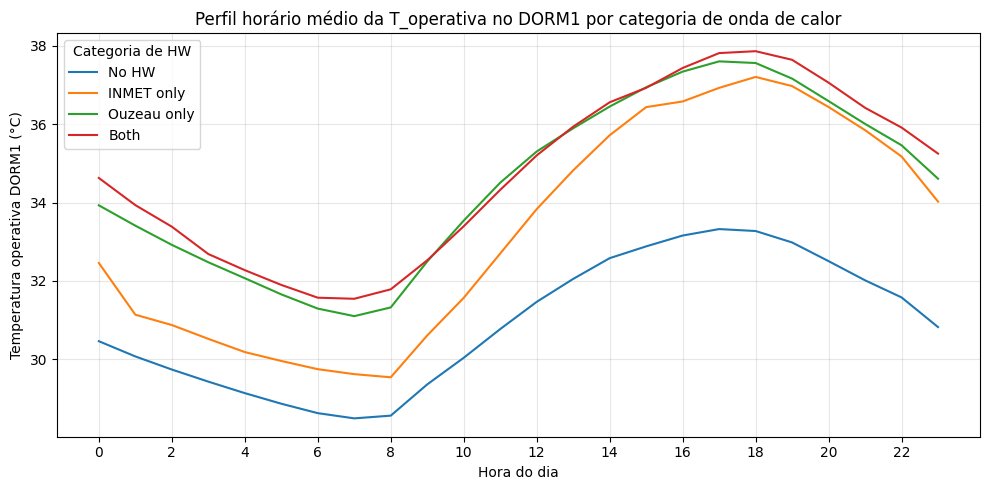

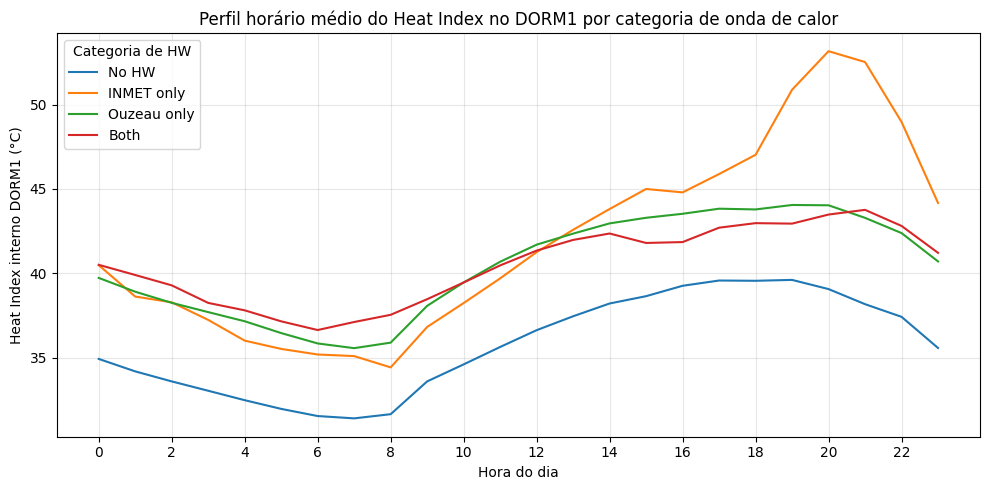

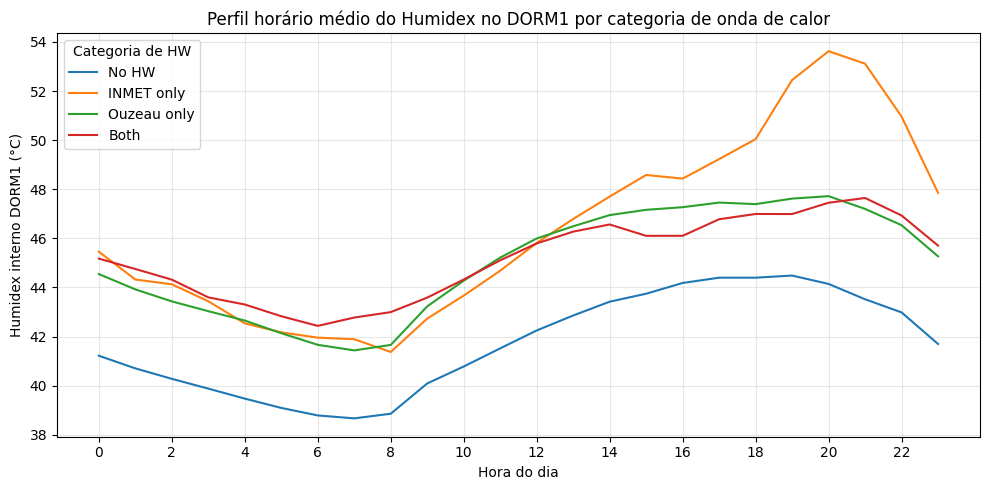

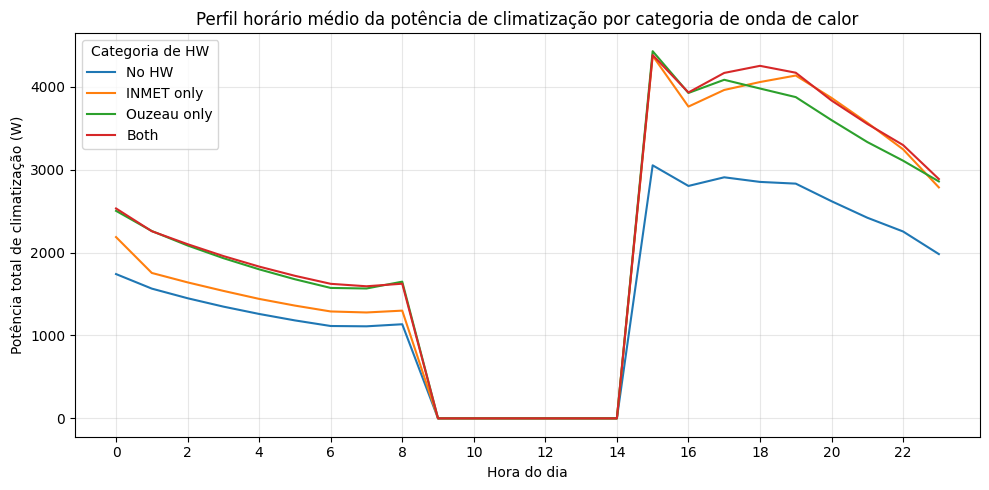

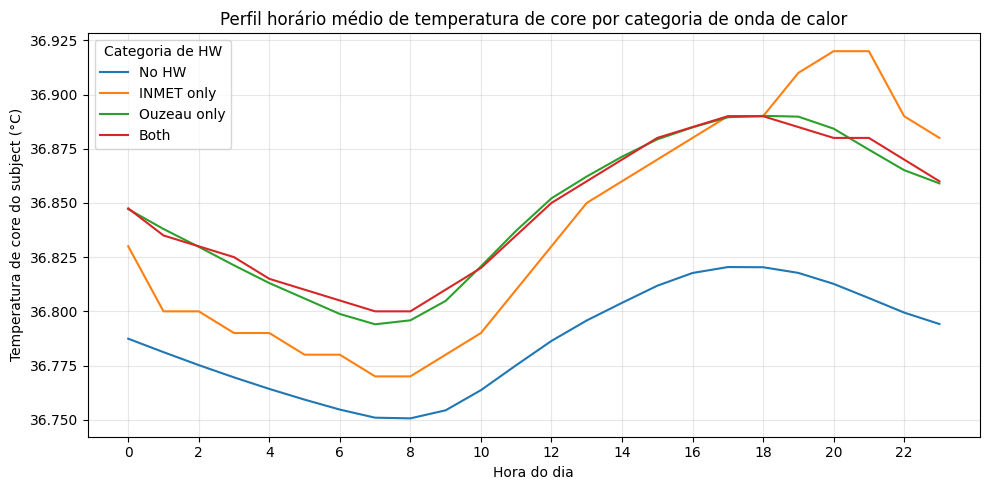

In [26]:
# -------- 1) Perfis horários médios por categoria de HW --------
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)
prof_long = profiles.reset_index()  # traz 'hour' como coluna

# Paleta consistente
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

# -------- 2) Função genérica pra plotar um indicador --------
def plot_indicator(col, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 5))

    for name, color in colors.items():
        sub = prof_long[prof_long["HW_category"] == name]
        ax.plot(
            sub["hour"],
            sub[col],
            label=name,
            color=color,
        )

    ax.set_xlabel("Hora do dia")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Categoria de HW")
    plt.xticks(range(0, 24, 2))
    plt.tight_layout()
    plt.show()

# -------- 3) Gerar os gráficos individuais --------

# (a) Temperatura operativa no dormitório
plot_indicator(
    col="vn_DORM1_Top_C",
    ylabel="Temperatura operativa DORM1 (°C)",
    title="Perfil horário médio da T_operativa no DORM1 por categoria de onda de calor"
)

# (b) Heat Index
plot_indicator(
    col="vn_DORM1_HeatIndex_C",
    ylabel="Heat Index interno DORM1 (°C)",
    title="Perfil horário médio do Heat Index no DORM1 por categoria de onda de calor"
)

# (c) Humidex
plot_indicator(
    col="vn_DORM1_HumidityIndex",
    ylabel="Humidex interno DORM1 (°C)",
    title="Perfil horário médio do Humidex no DORM1 por categoria de onda de calor"
)

# (d) Potência total de climatização (soma das zonas)
plot_indicator(
    col="ac_total_cool_W",
    ylabel="Potência total de climatização (W)",
    title="Perfil horário médio da potência de climatização por categoria de onda de calor"
)

# (e) Potência total de climatização (soma das zonas)
plot_indicator(
    col="jos3_t_core",
    ylabel="Temperatura de core do subject (°C)",
    title="Perfil horário médio de temperatura de core por categoria de onda de calor"
)

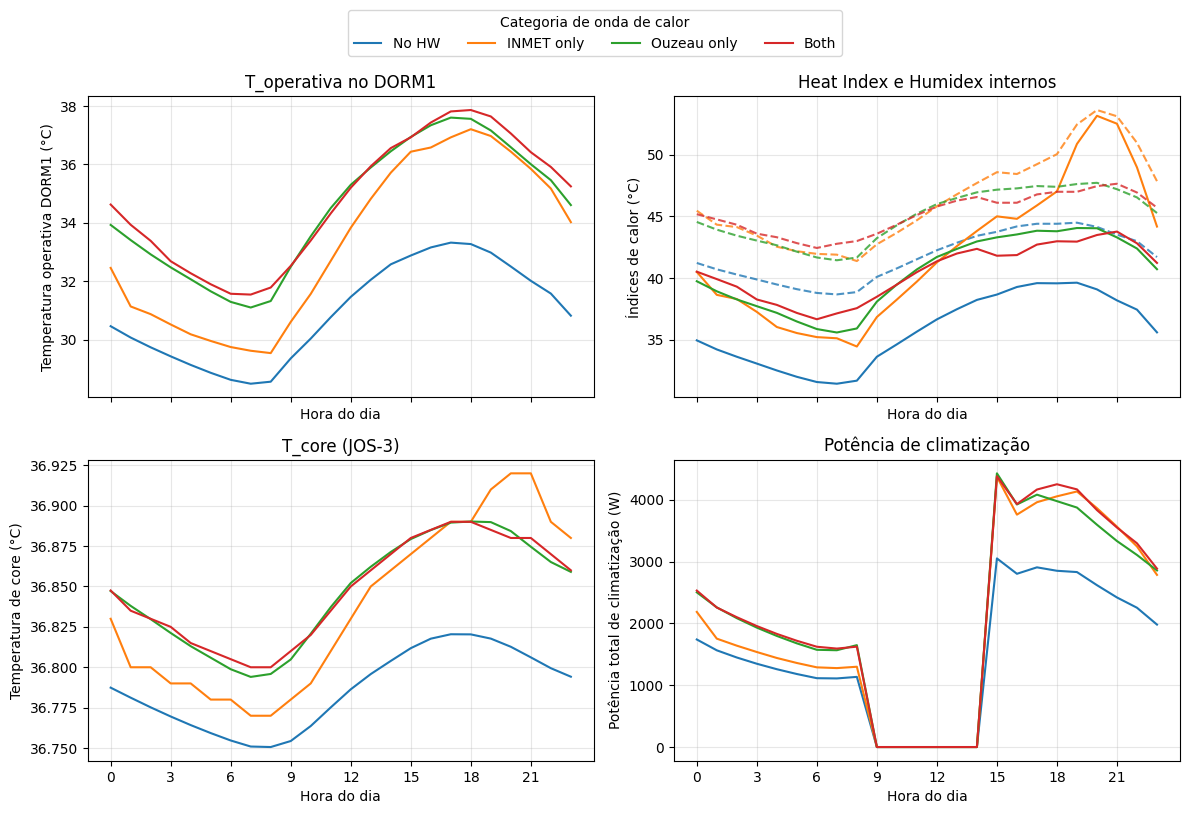

In [27]:
# -------- 1) Perfis horários médios por categoria de HW --------
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)
prof_long = profiles.reset_index()  # traz 'hour' como coluna

# Paleta consistente
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

# -------- 2) Grid 2x2 de subplots --------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

# Config por subplot
plots_cfg = [
    ("vn_DORM1_Top_C",
     "Temperatura operativa DORM1 (°C)",
     "T_operativa no DORM1"),
    ("HI+Humidex",          # marcador especial pra tratarmos diferente
     "Índices de calor (°C)",
     "Heat Index e Humidex internos"),
    ("jos3_t_core",
     "Temperatura de core (°C)",
     "T_core (JOS-3)"),
    ("ac_total_cool_W",
     "Potência total de climatização (W)",
     "Potência de climatização"),
]

all_lines = []

for ax, (col, ylabel, title) in zip(axes, plots_cfg):

    if col != "HI+Humidex":
        # Casos “normais”: uma variável por subplot
        lines = []
        for name, color in colors.items():
            sub = prof_long[prof_long["HW_category"] == name]
            (line,) = ax.plot(
                sub["hour"],
                sub[col],
                label=name,
                color=color,
            )
            lines.append(line)
        all_lines = lines  # mesma ordem de categorias em todos

    else:
        # Subplot especial: HI (linha cheia) + Humidex (linha pontilhada)
        for name, color in colors.items():
            sub = prof_long[prof_long["HW_category"] == name]

            # Heat Index - linha cheia
            ax.plot(
                sub["hour"],
                sub["vn_DORM1_HeatIndex_C"],
                label=f"{name} - HI",
                color=color,
                linestyle="-",
            )

            # Humidex - linha pontilhada
            ax.plot(
                sub["hour"],
                sub["vn_DORM1_HumidityIndex"],
                label=f"{name} - Humidex",
                color=color,
                linestyle="--",
                alpha=0.8,
            )

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 3))

# eixo x comum
for ax in axes:
    ax.set_xlabel("Hora do dia")

# Legenda: só por categoria de HW (cores), pra não virar carnaval
# cria linhas “fake” só pra legenda
legend_lines = []
legend_labels = []
for name, color in colors.items():
    (ln,) = axes[0].plot([], [], color=color, label=name)  # linha vazia
    legend_lines.append(ln)
    legend_labels.append(name)

fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    title="Categoria de onda de calor",
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.02),
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


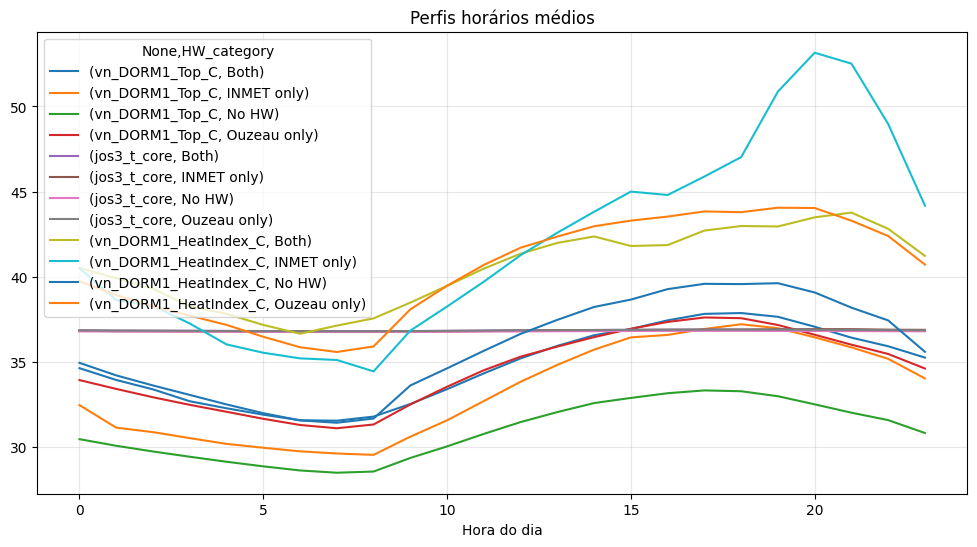

In [28]:
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    # média por hora do dia só das linhas daquela categoria
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)

(
    profiles[["vn_DORM1_Top_C", "jos3_t_core", "vn_DORM1_HeatIndex_C", "ac_total_cool_W", "HW_category"]]
    .reset_index()  # traz 'hour' de volta como coluna
    .pivot(index="hour", columns="HW_category", values=["vn_DORM1_Top_C",
                                                       "jos3_t_core",
                                                       "vn_DORM1_HeatIndex_C",
                                                       ])
    .plot(figsize=(12, 6), title="Perfis horários médios")
)

plt.xlabel("Hora do dia")
plt.grid(True, alpha=0.3)
plt.show()

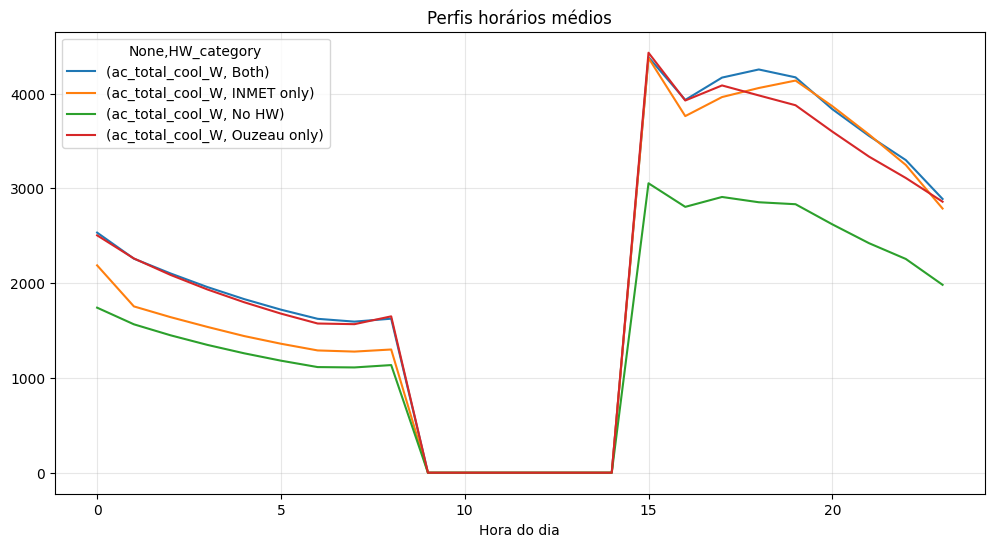

In [29]:
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    # média por hora do dia só das linhas daquela categoria
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)

(
    profiles[["ac_total_cool_W", "HW_category"]]
    .reset_index()  # traz 'hour' de volta como coluna
    .pivot(index="hour", columns="HW_category", values=["ac_total_cool_W"                                              
                                                       ])
    .plot(figsize=(12, 6), title="Perfis horários médios")
)

plt.xlabel("Hora do dia")
plt.grid(True, alpha=0.3)
plt.show()

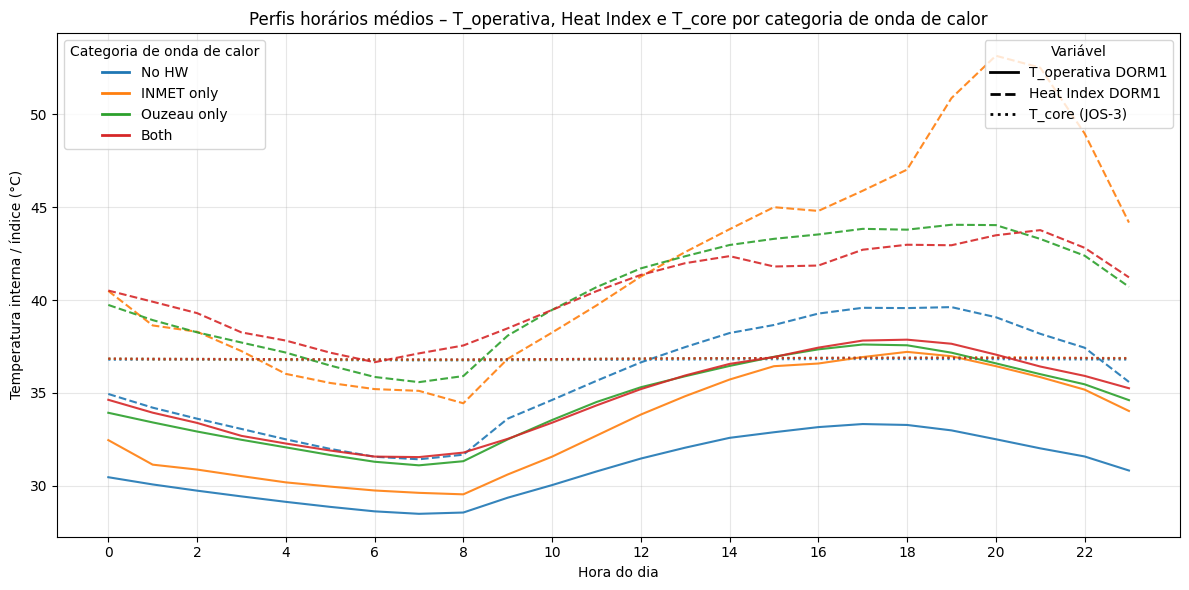

In [30]:
tmp = full.copy()
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)
prof_long = profiles.reset_index()  # traz 'hour' como coluna

# cores por categoria (igual aos outros gráficos)
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

# estilos por variável
var_styles = {
    "vn_DORM1_Top_C":      ("T_operativa DORM1", "-"),
    "vn_DORM1_HeatIndex_C":("Heat Index DORM1", "--"),
    "jos3_t_core":         ("T_core (JOS-3)", ":"),
}

fig, ax = plt.subplots(figsize=(12, 6))

# plota: para cada categoria (cor), todas as variáveis (linestyle diferente)
for cat_name, color in colors.items():
    sub_cat = prof_long[prof_long["HW_category"] == cat_name]

    for col, (label_var, ls) in var_styles.items():
        ax.plot(
            sub_cat["hour"],
            sub_cat[col],
            color=color,
            linestyle=ls,
            alpha=0.9,
            label=f"{cat_name} – {label_var}",
        )

ax.set_xlabel("Hora do dia")
ax.set_ylabel("Temperatura interna / índice (°C)")
ax.set_title("Perfis horários médios – T_operativa, Heat Index e T_core por categoria de onda de calor")
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)

# Agora arrumamos uma legenda mais limpa:
# 1) legenda de cores = categoria de HW
from matplotlib.lines import Line2D

legend_colors = [
    Line2D([0], [0], color=color, lw=2)
    for _, color in colors.items()
]
legend_color_labels = list(colors.keys())

# 2) legenda de estilos = variável
legend_styles = [
    Line2D([0], [0], color="black", linestyle=ls, lw=2)
    for _, (label_var, ls) in var_styles.items()
]
legend_style_labels = [label_var for label_var, _ in var_styles.values()]

# coloca as duas legendas
leg1 = ax.legend(
    handles=legend_colors,
    labels=legend_color_labels,
    title="Categoria de onda de calor",
    loc="upper left",
)
ax.add_artist(leg1)

ax.legend(
    handles=legend_styles,
    labels=legend_style_labels,
    title="Variável",
    loc="upper right",
)

plt.tight_layout()
plt.show()


In [31]:
# categorias já existentes
cats = {
    "No HW": ~(full["HW_INMET_bool"] | full["HW_OU_bool"]),
    "INMET only": (full["HW_INMET_bool"] & ~full["HW_OU_bool"]),
    "Ouzeau only": (~full["HW_INMET_bool"] & full["HW_OU_bool"]),
    "Both": (full["HW_INMET_bool"] & full["HW_OU_bool"]),
}

# paleta consistente
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

def plot_ecdf_by_hw(var, xlabel=None, title=None):
    plt.figure(figsize=(7,5))

    for name, mask in cats.items():
        x = full.loc[mask, var].dropna().values
        x_sorted = np.sort(x)
        y = np.arange(1, len(x_sorted)+1) / len(x_sorted)
        
        plt.plot(x_sorted, y, label=f"{name} (n={len(x_sorted)})",
                 color=colors[name], linewidth=2)

    plt.xlabel(xlabel if xlabel else var)
    plt.ylabel("ECDF")
    plt.title(title if title else f"ECDF de {var} por categoria de HW")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

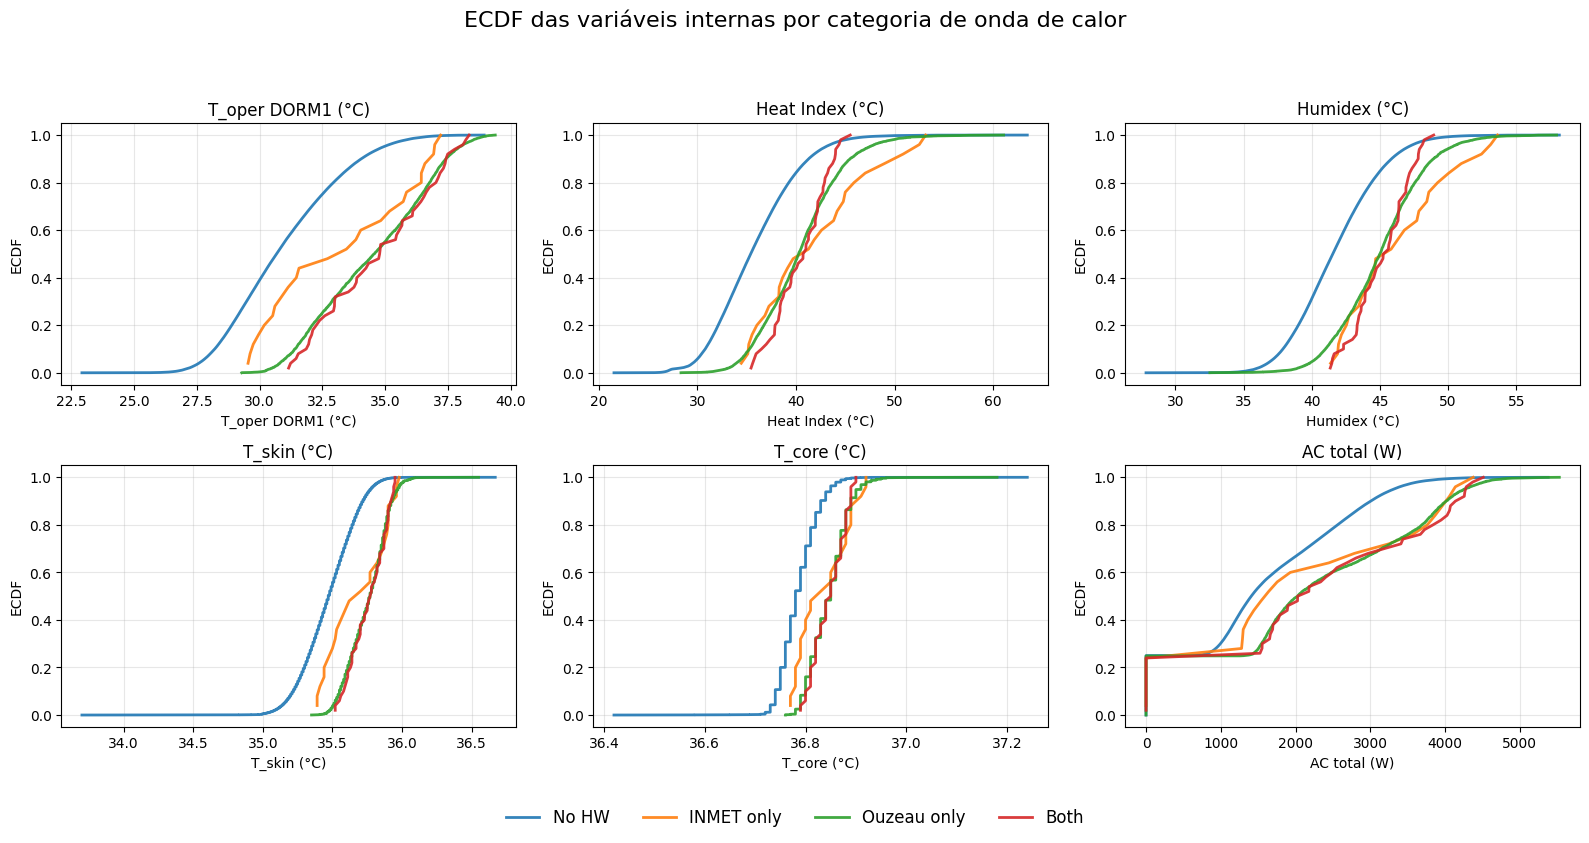

In [32]:
vars_ecdf = [
    ("vn_DORM1_Top_C",         "T_oper DORM1 (°C)"),
    ("vn_DORM1_HeatIndex_C",   "Heat Index (°C)"),
    ("vn_DORM1_HumidityIndex", "Humidex (°C)"),
    ("jos3_t_skin_mean",       "T_skin (°C)"),
    ("jos3_t_core",            "T_core (°C)"),
    ("ac_total_cool_W",        "AC total (W)"),
]

colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

cats = {
    "No HW": ~(full["HW_INMET_bool"] | full["HW_OU_bool"]),
    "INMET only": (full["HW_INMET_bool"] & ~full["HW_OU_bool"]),
    "Ouzeau only": (~full["HW_INMET_bool"] & full["HW_OU_bool"]),
    "Both": (full["HW_INMET_bool"] & full["HW_OU_bool"]),
}

# -----------------------------
#  CONFIGURAÇÕES DO GRID
# -----------------------------
ncols = 3
nrows = int(np.ceil(len(vars_ecdf) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
axes = axes.flatten()  # para indexar facilmente

# -----------------------------
#  PLOTAR CADA VARIÁVEL
# -----------------------------
for ax, (var, label) in zip(axes, vars_ecdf):

    for name, mask in cats.items():
        x = full.loc[mask, var].dropna().values
        x_sorted = np.sort(x)
        y = np.arange(1, len(x_sorted)+1) / len(x_sorted)

        ax.plot(
            x_sorted, y,
            color=colors[name],
            label=name,
            linewidth=2,
            alpha=0.9
        )

    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("ECDF")
    ax.grid(True, alpha=0.3)

# -----------------------------
#  REMOVER EIXOS VAZIOS (caso nvars < nrows*ncols)
# -----------------------------
for j in range(len(vars_ecdf), len(axes)):
    fig.delaxes(axes[j])

# -----------------------------
# LEGENDA GLOBAL 
# -----------------------------
fig.legend(
    cats.keys(),
    loc="lower center",
    ncol=4,
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.5, -0.02)
)

# -----------------------------
# TÍTULO GLOBAL
# -----------------------------
fig.suptitle("ECDF das variáveis internas por categoria de onda de calor", fontsize=16, y=1.02)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # deixa espaço para a legenda inferior
plt.show()

Qual método melhor prediz risco fisiológico?

In [33]:
full["risk_score"] = (
    0.5 * (full["jos3_t_skin_mean"] - full["jos3_t_skin_mean"].mean()) +
    0.5 * (full["jos3_t_core"] - full["jos3_t_core"].mean())
)

In [34]:
full.groupby(["HW_INMET_bool","HW_OU_bool"]).risk_score.mean().round(3)

HW_INMET_bool  HW_OU_bool
False          False        -0.002
               True          0.169
True           False         0.130
               True          0.174
Name: risk_score, dtype: float64

Indicadores das ondas de calor vs indoor 

In [35]:
def classify_event(row):
    IN = row["HW_INMET_bool"]
    OU = row["HW_OU_bool"]
    if IN and OU: return "Both"
    if IN and not OU: return "INMET only"
    if OU and not IN: return "Ouzeau only"
    return "No heatwave"

full["HW_category"] = full.apply(classify_event, axis=1)

In [36]:
full["AC_energy"] = (
    full.get("ac_SALA_Cool_E_kWh", 0)
    + full.get("ac_DORM1_Cool_E_kWh", 0)
    + full.get("ac_DORM2_Cool_E_kWh", 0)
)

full["AC_power"] = (
    full.get("ac_SALA_Cool_P_W", 0)
    + full.get("ac_DORM1_Cool_P_W", 0)
    + full.get("ac_DORM2_Cool_P_W", 0)
)

In [37]:
inmet_events = (
    full.dropna(subset=["INMET_hw_id"])
        .groupby("INMET_hw_id")
        .agg({
            "INMET_duration_d": "first",
            "INMET_intensity_c": "first",
            "INMET_severity_cday": "first",
            "ta_c": "mean",
            "jos3_t_skin_mean": "mean",
            "jos3_t_core": "mean",
            "vn_DORM1_HeatIndex_C": "mean",
            "vn_DORM1_HumidityIndex": "mean",
            "vn_DORM1_Top_C": "mean",
            "AC_energy": "sum",
            "AC_power": "mean",
            "HW_category": lambda x: x.mode()[0],
        })
        .rename(columns={
            "ta_c": "T_ar_mean",
            "jos3_t_skin_mean": "T_skin_mean",
            "jos3_t_core": "T_core_mean",
            "AC_energy": "AC_energy_total",
            "AC_power": "AC_power_mean"
        })
)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\183161484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("INMET_hw_id")


In [38]:
ouz_events = (
    full.dropna(subset=["OUZ_hw_id"])
        .groupby("OUZ_hw_id")
        .agg({
            "OUZ_duration_d": "first",
            "OUZ_intensity_c": "first",
            "OUZ_severity_cday": "first",
            "ta_c": "mean",
            "jos3_t_skin_mean": "mean",
            "jos3_t_core": "mean",
            "vn_DORM1_HeatIndex_C": "mean",
            "vn_DORM1_HumidityIndex": "mean",
            "vn_DORM1_Top_C": "mean",
            "AC_energy": "sum",
            "AC_power": "mean",
            "HW_category": lambda x: x.mode()[0],
        })
        .rename(columns={
            "ta_c": "T_ar_mean",
            "jos3_t_skin_mean": "T_skin_mean",
            "jos3_t_core": "T_core_mean",
            "AC_energy": "AC_energy_total",
            "AC_power": "AC_power_mean"
        })
)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\282518093.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("OUZ_hw_id")


In [39]:
event_summary = (
    pd.concat([
        inmet_events.assign(method="INMET"),
        ouz_events.assign(method="Ouzeau")
    ])
    .groupby("HW_category")
    .agg({
        "T_ar_mean": "mean",
        "T_skin_mean": "mean",
        "T_core_mean": "mean",
        "vn_DORM1_HeatIndex_C": "mean",
        "vn_DORM1_HumidityIndex": "mean",
        "vn_DORM1_Top_C": "mean",
        "AC_energy_total": "mean",
        "AC_power_mean": "mean",
        "INMET_duration_d": "mean",
        "OUZ_duration_d": "mean",
        "INMET_intensity_c": "mean",
        "OUZ_intensity_c": "mean",
        "INMET_severity_cday": "mean",
        "OUZ_severity_cday": "mean"
    })
    .round(2)
)

In [40]:
event_summary

,T_ar_mean,T_skin_mean,T_core_mean,vn_DORM1_HeatIndex_C,vn_DORM1_HumidityIndex,vn_DORM1_Top_C,AC_energy_total,AC_power_mean,INMET_duration_d,OUZ_duration_d,INMET_intensity_c,OUZ_intensity_c,INMET_severity_cday,OUZ_severity_cday
HW_category,,,,,,,,,,,,,,
Both,31.09,35.78,36.85,40.77,45.35,35.09,105.64,2200.76,2.0,NaN,31.42,NaN,0.89,NaN
INMET only,29.71,35.73,36.85,43.41,47.36,33.74,98.35,2048.95,2.0,NaN,30.25,NaN,0.67,NaN
Ouzeau only,30.03,35.74,36.84,40.13,44.81,34.29,355.07,2053.45,NaN,7.15,NaN,31.31,NaN,5.84
